In [1]:
# to auto reload the modified module
% load_ext autoreload
% autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

from utils import *
from data import MnistTF
from nn_kd import *
from layers import *
# from models import *

/home/deep3072/anaconda2/envs/tu36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
# session settings
session = create_session(gpu_id='1')
check_available_device()
# seed settings
set_rand_seed(0)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10502658107414097766
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4402380800
locality {
  bus_id: 1
}
incarnation: 9513170944127299341
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [4]:
# read Mnist data
try_cls2 = True
if try_cls2:
    mnist = MnistTF()
    X_train, y_train = mnist.get_train_data()
    X_val, y_val = mnist.get_validation_data()
    X_test, y_test = mnist.get_test_data()
    print_obj(X_train, 'X_train')
    print_obj(y_train, 'y_train')
    print_obj(X_val, 'X_val')
    print_obj(y_val, 'y_val')
    print_obj(X_test, 'X_test')
    print_obj(y_test, 'y_test')
    input_dims = X_train.shape[1]
    output_dims = y_train.shape[1]
    print_obj(input_dims, 'input_dims')
    print_obj(output_dims, 'output_dims')


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
X_train <class 'numpy.ndarray'> (55000, 784)
y_train <class 'numpy.ndarray'> (55000, 10)
X_val <class 'numpy.ndarray'> (5000, 784)
y_val <class 'numpy.ndarray'> (5000, 10)
X_test <class 'numpy.ndarray'> (10000, 784)
y_test <class 'numpy.ndarray'> (10000, 10)
input_dims <class 'int'> 784
output_dims <class 'int'> 10


In [5]:
def build_big_model(input_dims, output_dims, session):

    bigmodel = SoftenedNN(
        input_dims=input_dims
        , output_dims=output_dims
        , session=session
        , dtype_X=tf.float32
        , dtype_y=tf.float32)

#     bigmodel.add_layer(
#         Dropout(inputs=bigmodel.h[-1], keep_prob=0.8))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=1200, activation_fn=tf.nn.relu))
#     bigmodel.add_layer(
#         Dropout(inputs=bigmodel.h[-1], keep_prob=0.9))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=1200, activation_fn=tf.nn.relu))
#     bigmodel.add_layer(
#         Dropout(inputs=bigmodel.h[-1], keep_prob=0.9))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=output_dims, activation_fn=tf.nn.softmax))

    bigmodel.compile_nn(
        loss=tf.losses.softmax_cross_entropy(bigmodel.ys,bigmodel.logits)
        , opt=tf.train.AdamOptimizer(learning_rate=1e-3)
        , metrics = ['acc'])

    return bigmodel

In [6]:
if try_cls2:
    teacher = build_big_model(input_dims, output_dims, session)
    teacher.train(
        X=X_train
        ,y=y_train
        ,val_set=[X_val,y_val]
        ,batch_size=100
        ,n_epochs=100
        ,display_steps=100)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12863735619114727483
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4402380800
locality {
  bus_id: 1
}
incarnation: 7717900586420249246
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 6.0402083 , acc = 0.33 
Epoch 1 , step 100 , loss= 0.15822172 , acc = 0.95 
Epoch 1 , step 200 , loss= 0.11774536 , acc = 0.97 
Epoch 1 , step 300 , loss= 0.080887645 , acc = 0.98 
Epoch 1 , step 400 , loss= 0.076720215 , acc = 0.99 
Epoch 1 , step 500 , loss= 0.0538679 , acc = 0.99 
Epoch 1 , step 549 , loss= 0.089837104 val_loss= 0.09999467 , acc = 0.95 val acc = 0.9696 
Epoch 1 finished, loss= 0.21704133 val loss= 0.09999467 ,  acc = 0.95210916 val acc = 0.9696

Epoch 2 , step 50 , loss= 0.014415246 , acc = 1.0 
Epoch 2 , step 150 , loss= 0.06124512 , acc = 0.98 
Epoch 2 , step 250 , loss= 0.031584784 , acc = 0.

Epoch 17 , step 500 , loss= 0.0006920118 , acc = 1.0 
Epoch 17 , step 549 , loss= 3.8418857e-05 val_loss= 0.09368787 , acc = 1.0 val acc = 0.9836 
Epoch 17 finished, loss= 0.0015877774 val loss= 0.09368787 ,  acc = 0.99969083 val acc = 0.9836

Epoch 18 , step 50 , loss= 0.0005536146 , acc = 1.0 
Epoch 18 , step 150 , loss= 0.00041944455 , acc = 1.0 
Epoch 18 , step 250 , loss= 0.000578051 , acc = 1.0 
Epoch 18 , step 350 , loss= 0.0018005862 , acc = 1.0 
Epoch 18 , step 450 , loss= 0.0067470735 , acc = 1.0 
Epoch 18 , step 549 , loss= 0.0014709099 val_loss= 0.105244115 , acc = 1.0 val acc = 0.981 
Epoch 18 finished, loss= 0.0014519845 val loss= 0.105244115 ,  acc = 0.99967265 val acc = 0.981

Epoch 19 , step 0 , loss= 0.00016177159 , acc = 1.0 
Epoch 19 , step 100 , loss= 0.0016352355 , acc = 1.0 
Epoch 19 , step 200 , loss= 5.241826e-06 , acc = 1.0 
Epoch 19 , step 300 , loss= 0.0029343993 , acc = 1.0 
Epoch 19 , step 400 , loss= 0.00036840304 , acc = 1.0 
Epoch 19 , step 500 , loss= 

Epoch 34 , step 450 , loss= 0.00063715735 , acc = 1.0 
Epoch 34 , step 549 , loss= 0.00031689904 val_loss= 0.12988783 , acc = 1.0 val acc = 0.9832 
Epoch 34 finished, loss= 0.0003372584 val loss= 0.12988783 ,  acc = 0.9999272 val acc = 0.9832

Epoch 35 , step 0 , loss= 0.00012641019 , acc = 1.0 
Epoch 35 , step 100 , loss= 1.5985155e-06 , acc = 1.0 
Epoch 35 , step 200 , loss= 4.0753024e-05 , acc = 1.0 
Epoch 35 , step 300 , loss= 2.3276465e-05 , acc = 1.0 
Epoch 35 , step 400 , loss= 0.0005510799 , acc = 1.0 
Epoch 35 , step 500 , loss= 0.0010181702 , acc = 1.0 
Epoch 35 , step 549 , loss= 9.867204e-06 val_loss= 0.16724692 , acc = 1.0 val acc = 0.983 
Epoch 35 finished, loss= 0.000750268 val loss= 0.16724692 ,  acc = 0.9998908 val acc = 0.983

Epoch 36 , step 50 , loss= 3.445497e-05 , acc = 1.0 
Epoch 36 , step 150 , loss= 0.00012253616 , acc = 1.0 
Epoch 36 , step 250 , loss= 1.9374169e-05 , acc = 1.0 
Epoch 36 , step 350 , loss= 6.1987294e-07 , acc = 1.0 
Epoch 36 , step 450 , loss=

Epoch 51 , step 400 , loss= 1.1920487e-06 , acc = 1.0 
Epoch 51 , step 500 , loss= 6.1898186e-06 , acc = 1.0 
Epoch 51 , step 549 , loss= 2.8655368e-06 val_loss= 0.18145499 , acc = 1.0 val acc = 0.985 
Epoch 51 finished, loss= 0.00052894396 val loss= 0.18145499 ,  acc = 0.9998908 val acc = 0.985

Epoch 52 , step 50 , loss= 1.1507816e-05 , acc = 1.0 
Epoch 52 , step 150 , loss= 3.099439e-08 , acc = 1.0 
Epoch 52 , step 250 , loss= 1.1920929e-09 , acc = 1.0 
Epoch 52 , step 350 , loss= 6.437292e-08 , acc = 1.0 
Epoch 52 , step 450 , loss= 1.4185807e-07 , acc = 1.0 
Epoch 52 , step 549 , loss= 1.010869e-06 val_loss= 0.18270364 , acc = 1.0 val acc = 0.9846 
Epoch 52 finished, loss= 0.0004649537 val loss= 0.18270364 ,  acc = 0.999909 val acc = 0.9846

Epoch 53 , step 0 , loss= 5.3677563e-06 , acc = 1.0 
Epoch 53 , step 100 , loss= 1.8190792e-06 , acc = 1.0 
Epoch 53 , step 200 , loss= 9.217926e-05 , acc = 1.0 
Epoch 53 , step 300 , loss= 9.536741e-09 , acc = 1.0 
Epoch 53 , step 400 , loss=

Epoch 68 , step 350 , loss= 3.996289e-06 , acc = 1.0 
Epoch 68 , step 450 , loss= 1.1667421e-05 , acc = 1.0 
Epoch 68 , step 549 , loss= 3.5762724e-08 val_loss= 0.24459128 , acc = 1.0 val acc = 0.9844 
Epoch 68 finished, loss= 0.0003773384 val loss= 0.24459128 ,  acc = 0.999909 val acc = 0.9844

Epoch 69 , step 0 , loss= 0.0 , acc = 1.0 
Epoch 69 , step 100 , loss= 4.768371e-09 , acc = 1.0 
Epoch 69 , step 200 , loss= 0.0 , acc = 1.0 
Epoch 69 , step 300 , loss= 3.8146936e-08 , acc = 1.0 
Epoch 69 , step 400 , loss= 0.0028753309 , acc = 1.0 
Epoch 69 , step 500 , loss= 0.00028488264 , acc = 1.0 
Epoch 69 , step 549 , loss= 4.671913e-06 val_loss= 0.23712209 , acc = 1.0 val acc = 0.984 
Epoch 69 finished, loss= 7.487791e-05 val loss= 0.23712209 ,  acc = 0.9999818 val acc = 0.984

Epoch 70 , step 50 , loss= 7.0624774e-05 , acc = 1.0 
Epoch 70 , step 150 , loss= 0.000118649994 , acc = 1.0 
Epoch 70 , step 250 , loss= 6.198874e-08 , acc = 1.0 
Epoch 70 , step 350 , loss= 4.2596325e-06 , acc

Epoch 86 , step 50 , loss= 2.4556812e-07 , acc = 1.0 
Epoch 86 , step 150 , loss= 1.3113013e-08 , acc = 1.0 
Epoch 86 , step 250 , loss= 2.3841835e-08 , acc = 1.0 
Epoch 86 , step 350 , loss= 0.0 , acc = 1.0 
Epoch 86 , step 450 , loss= 4.2915268e-08 , acc = 1.0 
Epoch 86 , step 549 , loss= 2.3841855e-09 val_loss= 0.3300973 , acc = 1.0 val acc = 0.9826 
Epoch 86 finished, loss= 0.0007063655 val loss= 0.3300973 ,  acc = 0.9999272 val acc = 0.9826

Epoch 87 , step 0 , loss= 0.0 , acc = 1.0 
Epoch 87 , step 100 , loss= 3.2186456e-08 , acc = 1.0 
Epoch 87 , step 200 , loss= 0.0 , acc = 1.0 
Epoch 87 , step 300 , loss= 0.00014096015 , acc = 1.0 
Epoch 87 , step 400 , loss= 0.0 , acc = 1.0 
Epoch 87 , step 500 , loss= 2.1336186e-06 , acc = 1.0 
Epoch 87 , step 549 , loss= 1.5894648e-05 val_loss= 0.37111863 , acc = 1.0 val acc = 0.9822 
Epoch 87 finished, loss= 0.0010857634 val loss= 0.37111863 ,  acc = 0.9998726 val acc = 0.9822

Epoch 88 , step 50 , loss= 3.7907833e-07 , acc = 1.0 
Epoch 88

Plotting loss...


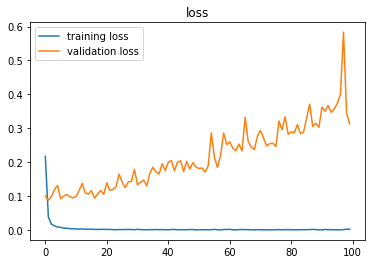

Plotting metrics...


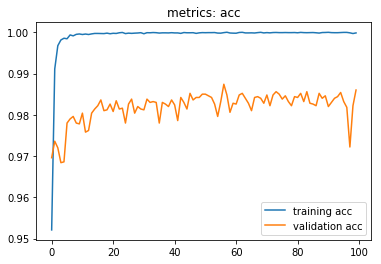

train {'acc': 0.9993455}
test {'acc': 0.9847}


In [7]:
if try_cls2:
    gc.collect()
    teacher.plt_loss()
    teacher.plt_metrics()
    train_metric = teacher.get_metrics(X_train, y_train)
    test_metric = teacher.get_metrics(X_test, y_test)
    print('train',train_metric)
    print('test',test_metric)

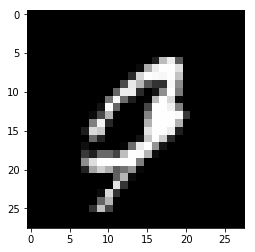

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
teacher.predict [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
teacher.predict_softened [[2.000e-04 8.000e-04 1.000e-04 1.000e-04 1.000e-03 0.000e+00 0.000e+00
  1.090e-02 2.000e-04 9.866e-01]]


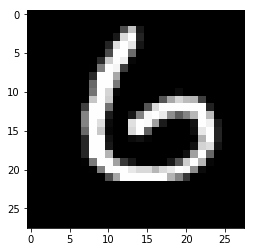

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
teacher.predict_softened [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


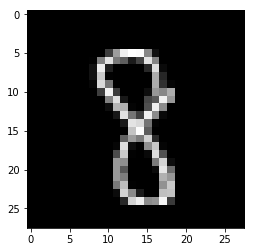

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
teacher.predict_softened [[0.000e+00 0.000e+00 3.000e-04 2.000e-04 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 9.994e-01 0.000e+00]]


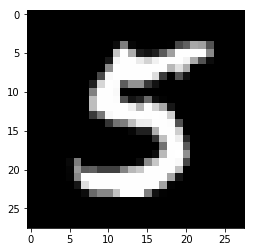

sample.max() 1.0
label [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
teacher.predict_softened [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


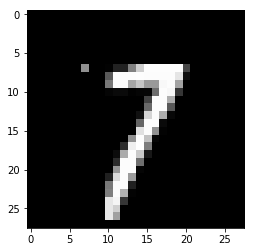

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
teacher.predict_softened [[0.000e+00 2.000e-04 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00
  9.983e-01 0.000e+00 1.300e-03]]


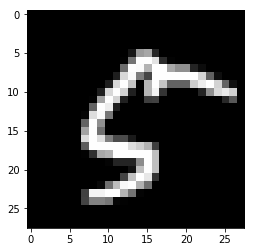

sample.max() 1.0
label [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
teacher.predict_softened [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 9.988e-01 0.000e+00
  0.000e+00 1.100e-03 1.000e-04]]


In [8]:
# plot and show sample
if try_cls2:
    n_samples = 6
    round_show = 4
    t = 10
    X_show = X_train
    n_data = X_show.shape[0]
    indices = np.random.choice(n_data,n_samples)
    for i in range(n_samples):
        sample = X_show[[indices[i]]]
        label = y_train[indices[i]]
        plt.imshow(sample.reshape((28,28)), cmap='gray')
        plt.show()
        pred = teacher.predict(sample)
        pred_t = teacher.predict_softened(sample, temperature=t)
#         pred_t2 = y_train_soft[indices[i]]
        print('sample.max()',sample.max())
        print('label',label)
        print('teacher.predict',np.round(pred,round_show))
        print('teacher.predict_softened',np.round(pred_t,round_show))
#         print('y_soft',np.round(pred_t2,round_show))
        #     teacher.predict()

In [9]:

def build_small_model(input_dims, output_dims, session, is_student):
    smallmodel = StudentNN(
        input_dims=input_dims
        , output_dims=output_dims
        , session=session
        , dtype_X=tf.float32
        , dtype_y=tf.float32)

    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=800,activation_fn=tf.nn.relu))
    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=800,activation_fn=tf.nn.relu))
    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=output_dims, activation_fn=tf.nn.softmax))

    if is_student:
        smallmodel.compile_student(
            loss_standard=tf.losses.softmax_cross_entropy(smallmodel.ys,smallmodel.logits)
            , opt=tf.train.AdamOptimizer(learning_rate=1e-3) #TODO: learning rate
            , metrics = ['acc']
        )
    else:
        smallmodel.compile_nn(
            loss=tf.losses.softmax_cross_entropy(smallmodel.ys,smallmodel.logits)
            , opt=tf.train.AdamOptimizer(learning_rate=1e-3)
            , metrics = ['acc']
        )
    return smallmodel

In [10]:
import gc
gc.collect()
if try_cls2:
    small = build_small_model(input_dims, output_dims, session, is_student=False)
    small.train(
        X=X_train
        ,y=y_train
        ,val_set=[X_val,y_val]
        ,batch_size=100
        ,n_epochs=50
        ,display_steps=100)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1923510304335108634
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 10583340129562418784
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 3.766683 , acc = 0.22 
Epoch 1 , step 100 , loss= 0.23211996 , acc = 0.94 
Epoch 1 , step 200 , loss= 0.14385466 , acc = 0.96 
Epoch 1 , step 300 , loss= 0.055054132 , acc = 0.99 
Epoch 1 , step 400 , loss= 0.11086819 , acc = 0.98 
Epoch 1 , step 500 , loss= 0.10786489 , acc = 0.98 
Epoch 1 , step 549 , loss= 0.12414671 val_loss= 0.10676975 , acc = 0.97 val acc = 0.9674 
Epoch 1 finished, loss= 0.1973799 val loss= 0.10676975 ,  acc = 0.9458364 val acc = 0.9674

Epoch 2 , step 50 , loss= 0.03558425 , acc = 0.99 
Epoch 2 , step 150 , loss= 0.025065698 , acc = 1.0 
Epoch 2 , step 250 , loss= 0.040482923 , acc = 0.99 


Epoch 17 , step 400 , loss= 0.0014651543 , acc = 1.0 
Epoch 17 , step 500 , loss= 0.0005914357 , acc = 1.0 
Epoch 17 , step 549 , loss= 0.0008395432 val_loss= 0.10023945 , acc = 1.0 val acc = 0.9822 
Epoch 17 finished, loss= 0.0027052264 val loss= 0.10023945 ,  acc = 0.99945444 val acc = 0.9822

Epoch 18 , step 50 , loss= 8.522123e-05 , acc = 1.0 
Epoch 18 , step 150 , loss= 0.00077523256 , acc = 1.0 
Epoch 18 , step 250 , loss= 0.0003059059 , acc = 1.0 
Epoch 18 , step 350 , loss= 0.0011983822 , acc = 1.0 
Epoch 18 , step 450 , loss= 0.0014359909 , acc = 1.0 
Epoch 18 , step 549 , loss= 0.0010804026 val_loss= 0.12356099 , acc = 1.0 val acc = 0.977 
Epoch 18 finished, loss= 0.0014560206 val loss= 0.12356099 ,  acc = 0.9998 val acc = 0.977

Epoch 19 , step 0 , loss= 0.000817994 , acc = 1.0 
Epoch 19 , step 100 , loss= 0.0005249094 , acc = 1.0 
Epoch 19 , step 200 , loss= 5.5238423e-05 , acc = 1.0 
Epoch 19 , step 300 , loss= 0.02535126 , acc = 0.99 
Epoch 19 , step 400 , loss= 0.0004070

Epoch 34 , step 350 , loss= 0.00022782707 , acc = 1.0 
Epoch 34 , step 450 , loss= 3.1194802e-05 , acc = 1.0 
Epoch 34 , step 549 , loss= 0.00013537107 val_loss= 0.12714644 , acc = 1.0 val acc = 0.9828 
Epoch 34 finished, loss= 0.00096070603 val loss= 0.12714644 ,  acc = 0.9997817 val acc = 0.9828

Epoch 35 , step 0 , loss= 8.982133e-06 , acc = 1.0 
Epoch 35 , step 100 , loss= 0.0004986549 , acc = 1.0 
Epoch 35 , step 200 , loss= 0.00021413181 , acc = 1.0 
Epoch 35 , step 300 , loss= 0.00019508306 , acc = 1.0 
Epoch 35 , step 400 , loss= 0.00056547055 , acc = 1.0 
Epoch 35 , step 500 , loss= 2.552251e-05 , acc = 1.0 
Epoch 35 , step 549 , loss= 8.58082e-05 val_loss= 0.12464768 , acc = 1.0 val acc = 0.9848 
Epoch 35 finished, loss= 0.00077684567 val loss= 0.12464768 ,  acc = 0.9998545 val acc = 0.9848

Epoch 36 , step 50 , loss= 5.3882087e-07 , acc = 1.0 
Epoch 36 , step 150 , loss= 3.0426843e-05 , acc = 1.0 
Epoch 36 , step 250 , loss= 6.61427e-06 , acc = 1.0 
Epoch 36 , step 350 , los

Small model
Plotting loss...


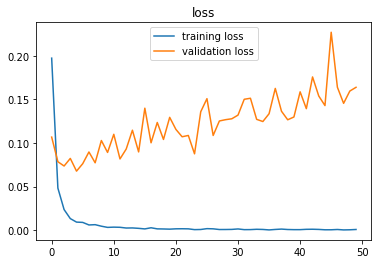

Plotting metrics...


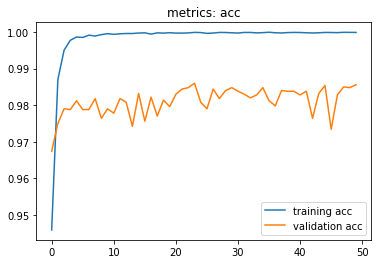

train {'acc': 0.99965453}
test {'acc': 0.9835}


In [11]:
if try_cls2:
    print('Small model')
    small.plt_loss()
    small.plt_metrics()
    train_metric = small.get_metrics(X_train, y_train)
    test_metric = small.get_metrics(X_test, y_test)
    print('train',train_metric)
    print('test',test_metric)

Training student with temperature = 2 , coef = 0.25 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4362790939441505212
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 15602308911981429534
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 2.9318829 , acc = 0.44 
t_cost <class 'dict'> 
get_batch : 8.000000207175617e-06
train_op : 0.04323999999996886
loss_train : 0.02405799999996816
metric batch : 0.009896000000026106
whole : 0.077541999999994
display_whole : 0.03427699999997458
Epoch 1 , step 100 , loss= 0.84777564 , acc = 0.97 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.012588999999934458
loss_train : 0.011187000000063563
metric batch : 0.00937500000009095
whole : 0.033479000000170345
display_whole : 0.020876999999927648
Epoch 1 , step 200 , loss= 0.8063834 , acc = 0.95

Epoch 5 , step 100 , loss= 0.63324153 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009389000000055603
loss_train : 0.008741999999983818
metric batch : 0.0032089999999698193
whole : 0.021603000000141037
display_whole : 0.01219800000012583
Epoch 5 , step 200 , loss= 0.647283 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.009262000000035187
loss_train : 0.010541999999986729
metric batch : 0.006986000000097192
whole : 0.02726600000005419
display_whole : 0.01799099999993814
Epoch 5 , step 300 , loss= 0.62426245 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.000000207175617e-06
train_op : 0.008354999999937718
loss_train : 0.0031970000000001164
metric batch : 0.005094999999982974
whole : 0.016982999999981985
display_whole : 0.008618000000069514
Epoch 5 , step 400 , loss= 0.60713655 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.009774999999990541
loss_train : 0.0029580000000350992


Epoch 9 , step 300 , loss= 0.61565495 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.009607000000187327
loss_train : 0.0057990000000245345
metric batch : 0.0045780000000377186
whole : 0.020410999999967316
display_whole : 0.01079000000004271
Epoch 9 , step 400 , loss= 0.6087857 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999868639861e-06
train_op : 0.011355000000094151
loss_train : 0.0073840000000018335
metric batch : 0.009283999999979642
whole : 0.02839399999993475
display_whole : 0.017017000000123517
Epoch 9 , step 500 , loss= 0.6192299 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.008062999999992826
loss_train : 0.018563000000085594
metric batch : 0.008822999999893
whole : 0.035742000000027474
display_whole : 0.027667000000064945
Epoch 9 , step 549 , loss= 0.6095467 val_loss= 0.6631553 , acc = 1.0 val acc = 0.9816 
Epoch 9 finished, loss= 0.6818985 t_cost <class 'dict'> 
get_batch : 5.000000101063051e-0

Epoch 13 , step 500 , loss= 0.60952586 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.008452999999917665
loss_train : 0.01731599999993705
metric batch : 0.009237000000211992
whole : 0.03565100000014354
display_whole : 0.027182000000038897
Epoch 13 , step 549 , loss= 0.61495835 val_loss= 0.6608768 , acc = 1.0 val acc = 0.9828 
Epoch 13 finished, loss= 0.65905154 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.00991199999998571
loss_train : 0.011320999999952619
loss_val : 0.029966000000058557
metric_val : 0.02348899999992682
metric batch : 0.004076999999824693
whole : 0.07952599999998711
display_whole : 0.0696020000000317
Epoch 14 , step 50 , loss= 0.6132374 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.01093500000001768
loss_train : 0.007379000000128144
metric batch : 0.0071120000000064465
whole : 0.025942999999870153
display_whole : 0.014998000000105094
Epoch 14 , step 150 , loss= 0.5849478 ,

Epoch 18 , step 50 , loss= 0.61088073 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000101063051e-06
train_op : 0.01136299999984658
loss_train : 0.011473999999907392
metric batch : 0.002261999999973341
whole : 0.02532599999995
display_whole : 0.013952999999901294
Epoch 18 , step 150 , loss= 0.6179489 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.010508999999956359
loss_train : 0.01033000000006723
metric batch : 0.0068280000000413565
whole : 0.028086000000030253
display_whole : 0.017564999999876818
Epoch 18 , step 250 , loss= 0.58434576 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.010654999999815118
loss_train : 0.015317999999979293
metric batch : 0.007491999999956533
whole : 0.033768000000009124
display_whole : 0.02310099999999693
Epoch 18 , step 350 , loss= 0.5802723 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.000000217274646e-06
train_op : 0.010839999999916472
loss_train : 0.008278999999902226
met

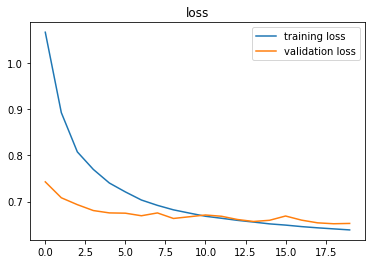

Plotting metrics...


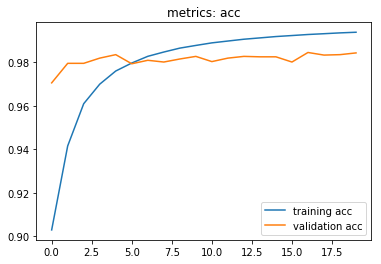

train {'acc': 0.9999091}
test {'acc': 0.9801}

Training student with temperature = 2 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17055734234221429359
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 17425906772094332274
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 6.686184 , acc = 0.12 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.033633999999892694
loss_train : 0.019768999999996595
metric batch : 0.015240000000176224
whole : 0.06891099999984363
display_whole : 0.035251000000016575
Epoch 1 , step 100 , loss= 2.4285827 , acc = 0.86 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.010592999999971653
loss_train : 0.007777999999916574
metric batch : 0.008246999999983018
whole : 0.027201999999988402
display_whole : 0.016620999999986452


Epoch 5 , step 100 , loss= 1.9972738 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.003829999999879874
loss_train : 0.00384699999995064
metric batch : 0.009324999999989814
whole : 0.017399000000068554
display_whole : 0.013557999999875392
Epoch 5 , step 200 , loss= 2.0607924 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.006705000000010841
loss_train : 0.00366400000007161
metric batch : 0.009330000000090877
whole : 0.02035599999999249
display_whole : 0.01364000000012311
Epoch 5 , step 300 , loss= 2.1211648 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.007503999999926236
loss_train : 0.02250899999989997
metric batch : 0.007573999999976877
whole : 0.03793099999984406
display_whole : 0.03040999999984706
Epoch 5 , step 400 , loss= 2.0023556 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000101063051e-06
train_op : 0.009492000000136613
loss_train : 0.01580699999999524
metric bat

Epoch 9 , step 300 , loss= 2.0880272 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.003065999999989799
loss_train : 0.007180999999945925
metric batch : 0.00402299999996103
whole : 0.014550000000099317
display_whole : 0.011473000000023603
Epoch 9 , step 400 , loss= 2.0232606 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.009544999999889114
loss_train : 0.005008000000088941
metric batch : 0.0016540000001441513
whole : 0.01663900000016838
display_whole : 0.007082000000082189
Epoch 9 , step 500 , loss= 2.0202723 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011500000000069122
loss_train : 0.0031089999999949214
metric batch : 0.007706999999982145
whole : 0.022584000000051674
display_whole : 0.01107200000001285
Epoch 9 , step 549 , loss= 2.049731 val_loss= 2.0935023 , acc = 1.0 val acc = 0.9674 
Epoch 9 finished, loss= 2.169527 t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06


Epoch 13 , step 500 , loss= 1.9736722 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.006435999999894193
loss_train : 0.02038700000002791
metric batch : 0.003146000000015192
whole : 0.030295999999907508
display_whole : 0.02384600000004866
Epoch 13 , step 549 , loss= 2.1034012 val_loss= 2.083081 , acc = 1.0 val acc = 0.9688 
Epoch 13 finished, loss= 2.1216657 t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.01118399999995745
loss_train : 0.0073260000001482695
loss_val : 0.04106200000001081
metric_val : 0.023647999999866443
metric batch : 0.004436999999825275
whole : 0.08848999999986518
display_whole : 0.0772900000001755
Epoch 14 , step 50 , loss= 1.9900239 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0051119999998263665
loss_train : 0.005688000000191096
metric batch : 0.008042999999815947
whole : 0.01914899999997033
display_whole : 0.014026000000058048
Epoch 14 , step 150 , loss= 2.0034359 , ac

Epoch 18 , step 50 , loss= 1.9927332 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.01001100000007682
loss_train : 0.0039249999999810825
metric batch : 0.0018779999998059793
whole : 0.016202000000021144
display_whole : 0.006176999999979671
Epoch 18 , step 150 , loss= 1.9847224 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.00930000000016662
loss_train : 0.009699999999838838
metric batch : 0.008479000000079395
whole : 0.027743999999984226
display_whole : 0.018428999999969164
Epoch 18 , step 250 , loss= 2.0580044 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.010568000000148459
loss_train : 0.0046589999999469
metric batch : 0.004815999999891574
whole : 0.020409999999856154
display_whole : 0.009829999999965366
Epoch 18 , step 350 , loss= 1.9627513 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.009968000000071697
loss_train : 0.017646000000013373
m

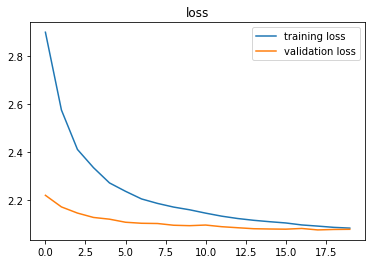

Plotting metrics...


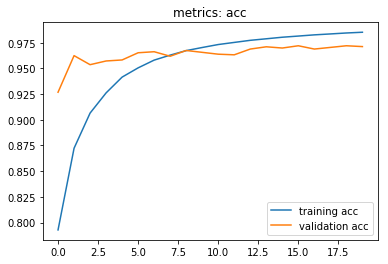

train {'acc': 0.9989273}
test {'acc': 0.9662}

Training student with temperature = 2 , coef = 4 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1652971653733537739
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3649503232
locality {
  bus_id: 1
}
incarnation: 442920142612159157
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 12.831646 , acc = 0.07 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.034333999999944353
loss_train : 0.02397500000006403
metric batch : 0.014917999999852327
whole : 0.07356000000004315
display_whole : 0.039207000000033077
Epoch 1 , step 100 , loss= 7.549921 , acc = 0.49 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009766000000126951
loss_train : 0.00797799999986637
metric batch : 0.0036689999999452994
whole : 0.02172500000006039
display_whole : 0.011944999999968786
Epoch

Epoch 5 , step 100 , loss= 6.7786503 , acc = 0.58 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011911999999938416
loss_train : 0.013380000000097425
metric batch : 0.007569000000103188
whole : 0.03318799999988187
display_whole : 0.02126399999997375
Epoch 5 , step 200 , loss= 6.895208 , acc = 0.52 
t_cost <class 'dict'> 
get_batch : 5.000000101063051e-06
train_op : 0.011157000000139305
loss_train : 0.010322000000087428
metric batch : 0.009060999999974229
whole : 0.03092800000013085
display_whole : 0.019758000000138054
Epoch 5 , step 300 , loss= 6.9482737 , acc = 0.46 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.007250000000112777
loss_train : 0.014262000000144326
metric batch : 0.007873000000017782
whole : 0.029660999999805426
display_whole : 0.022397000000182743
Epoch 5 , step 400 , loss= 7.087184 , acc = 0.45 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.01015800000004674
loss_train : 0.005940000000009604
metr

Epoch 9 , step 300 , loss= 6.9045563 , acc = 0.45 
t_cost <class 'dict'> 
get_batch : 6.999999868639861e-06
train_op : 0.006327000000055705
loss_train : 0.01111599999990176
metric batch : 0.008958000000120592
whole : 0.026953000000048633
display_whole : 0.020612999999912063
Epoch 9 , step 400 , loss= 6.9262905 , acc = 0.44 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.011021999999911714
loss_train : 0.029858000000103857
metric batch : 0.0019119999999475112
whole : 0.04310000000009495
display_whole : 0.03206500000010237
Epoch 9 , step 500 , loss= 6.933907 , acc = 0.48 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.009399000000030355
loss_train : 0.011815000000069631
metric batch : 0.008653000000094835
whole : 0.030109999999922366
display_whole : 0.020700999999917258
Epoch 9 , step 549 , loss= 6.753751 val_loss= 6.8920465 , acc = 0.44 val acc = 0.4676 
Epoch 9 finished, loss= 6.989964 t_cost <class 'dict'> 
get_batch : 5.999999984851456e-0

Epoch 13 , step 500 , loss= 6.584783 , acc = 0.36 
t_cost <class 'dict'> 
get_batch : 1.1000000085914508e-05
train_op : 0.011668999999983498
loss_train : 0.008129000000053566
metric batch : 0.004403999999794905
whole : 0.024485000000140644
display_whole : 0.012797999999975218
Epoch 13 , step 549 , loss= 6.8516245 val_loss= 6.8738556 , acc = 0.51 val acc = 0.4416 
Epoch 13 finished, loss= 6.9099092 t_cost <class 'dict'> 
get_batch : 5.000000101063051e-06
train_op : 0.0046689999999216525
loss_train : 0.00363100000004124
loss_val : 0.03996299999994335
metric_val : 0.022545000000036453
metric batch : 0.0021899999999277497
whole : 0.07371899999998277
display_whole : 0.06903799999986404
Epoch 14 , step 50 , loss= 6.806543 , acc = 0.45 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.006583999999975276
loss_train : 0.0031229999999595748
metric batch : 0.0074619999998049025
whole : 0.017451999999821055
display_whole : 0.010854999999992287
Epoch 14 , step 150 , loss= 6.558

Epoch 18 , step 50 , loss= 6.692008 , acc = 0.47 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.006673999999975422
loss_train : 0.008802999999943495
metric batch : 0.008272000000033586
whole : 0.024180000000114887
display_whole : 0.0174890000000687
Epoch 18 , step 150 , loss= 6.861271 , acc = 0.48 
t_cost <class 'dict'> 
get_batch : 9.000000090964022e-06
train_op : 0.010483999999905791
loss_train : 0.008080000000063592
metric batch : 0.004151999999976397
whole : 0.023155999999971755
display_whole : 0.012658999999985099
Epoch 18 , step 250 , loss= 6.7766376 , acc = 0.54 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.006718999999975495
loss_train : 0.004073000000062166
metric batch : 0.009316000000126223
whole : 0.02043099999991682
display_whole : 0.013698000000204047
Epoch 18 , step 350 , loss= 6.791901 , acc = 0.47 
t_cost <class 'dict'> 
get_batch : 5.000000101063051e-06
train_op : 0.010154999999940628
loss_train : 0.006088999999974476
m

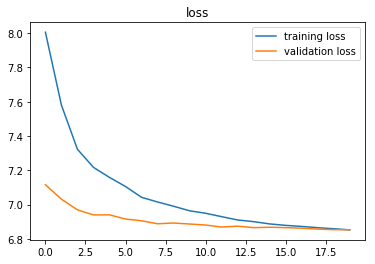

Plotting metrics...


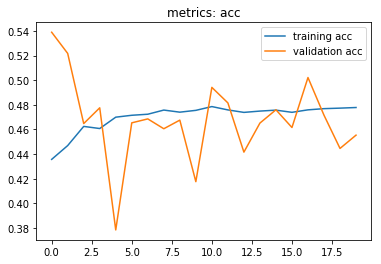

train {'acc': 0.48085454}
test {'acc': 0.4499}

Training student with temperature = 4 , coef = 0.0625 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9987466667437823611
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 2457457378391496951
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 2.4785848 , acc = 0.45 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0425399999999172
loss_train : 0.026121999999986656
metric batch : 0.018996000000015556
whole : 0.08803999999986445
display_whole : 0.045478000000002794
Epoch 1 , step 100 , loss= 0.4369741 , acc = 0.92 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.009213999999929001
loss_train : 0.014359000000013111
metric batch : 0.0041169999999510765
whole : 0.02807499999994434
display_whole : 0.0188479999999344

Epoch 5 , step 100 , loss= 0.172929 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011145000000169603
loss_train : 0.010176000000001295
metric batch : 0.004437000000052649
whole : 0.026126999999860345
display_whole : 0.014967000000069675
Epoch 5 , step 200 , loss= 0.16818735 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0049579999999878055
loss_train : 0.0037370000000009895
metric batch : 0.005047999999987951
whole : 0.014159999999947104
display_whole : 0.009189999999989595
Epoch 5 , step 300 , loss= 0.16986558 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.007057000000031621
loss_train : 0.025126999999883992
metric batch : 0.009209000000055312
whole : 0.04189199999996163
display_whole : 0.0348229999999603
Epoch 5 , step 400 , loss= 0.16986088 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999984851456e-06
train_op : 0.0052470000000539585
loss_train : 0.014171999999916807


Epoch 9 , step 300 , loss= 0.17582707 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.010702000000037515
loss_train : 0.0029800000002069282
metric batch : 0.0018979999999828578
whole : 0.016076999999768304
display_whole : 0.005364000000099622
Epoch 9 , step 400 , loss= 0.17385851 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.009763000000020838
loss_train : 0.021833999999671505
metric batch : 0.008008999999674415
whole : 0.03992699999980687
display_whole : 0.030148999999710213
Epoch 9 , step 500 , loss= 0.17206061 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.005434000000150263
loss_train : 0.0028069999998479034
metric batch : 0.009342999999716994
whole : 0.017864999999801512
display_whole : 0.012419000000136293
Epoch 9 , step 549 , loss= 0.18064286 val_loss= 0.22780547 , acc = 1.0 val acc = 0.983 
Epoch 9 finished, loss= 0.23112713 t_cost <class 'dict'> 
get_batch : 5.0000003284

Epoch 13 , step 500 , loss= 0.15803948 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.000000434549293e-06
train_op : 0.006921000000147615
loss_train : 0.008687000000008993
metric batch : 0.009704000000056112
whole : 0.02564799999981915
display_whole : 0.018712999999934254
Epoch 13 , step 549 , loss= 0.15893109 val_loss= 0.20277756 , acc = 1.0 val acc = 0.9872 
Epoch 13 finished, loss= 0.21017426 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009977000000162661
loss_train : 0.0027319999999235733
loss_val : 0.03539200000022902
metric_val : 0.02268000000003667
metric batch : 0.008658000000195898
whole : 0.08009399999991729
display_whole : 0.07010200000013356
Epoch 14 , step 50 , loss= 0.15764451 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009391999999934342
loss_train : 0.0116280000002007
metric batch : 0.008659999999963475
whole : 0.030095999999957712
display_whole : 0.020688999999947555
Epoch 14 , step 150 , loss= 0.157654

Epoch 18 , step 50 , loss= 0.15660043 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.011693999999806692
loss_train : 0.007839000000330998
metric batch : 0.005290000000059081
whole : 0.02525900000000547
display_whole : 0.013554999999996653
Epoch 18 , step 150 , loss= 0.15551203 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.009997000000112166
loss_train : 0.00843299999996816
metric batch : 0.0035249999996267434
whole : 0.022374000000127126
display_whole : 0.012361999999939144
Epoch 18 , step 250 , loss= 0.15657909 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011473999999907392
loss_train : 0.0063850000001366425
metric batch : 0.00586299999986295
whole : 0.024158000000170432
display_whole : 0.012674000000060914
Epoch 18 , step 350 , loss= 0.154557 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.003995000000031723
loss_train : 0.01164500000004409

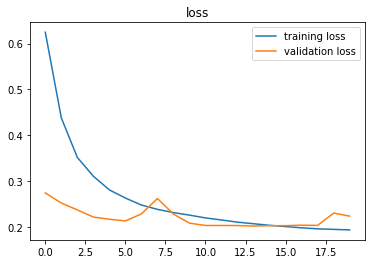

Plotting metrics...


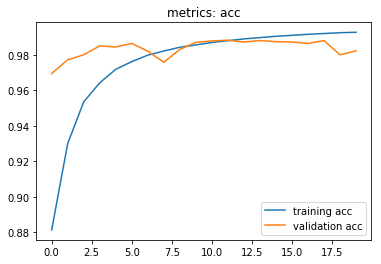

train {'acc': 0.9985818}
test {'acc': 0.9801}

Training student with temperature = 4 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5201755143817207595
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 11033594897138368475
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 5.6771398 , acc = 0.29 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.04628599999978178
loss_train : 0.02779999999984284
metric batch : 0.017001999999592954
whole : 0.0913909999999305
display_whole : 0.045086000000083004
Epoch 1 , step 100 , loss= 2.6031783 , acc = 0.89 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.010856000000330823
loss_train : 0.0068669999996018305
metric batch : 0.0032889999997678387
whole : 0.021371999999701075
display_whole : 0.010502999999971507
E

Epoch 5 , step 100 , loss= 2.321695 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.009666999999808468
loss_train : 0.019715000000360305
metric batch : 0.004156999999850086
whole : 0.03383200000007491
display_whole : 0.02414600000020073
Epoch 5 , step 200 , loss= 2.3053508 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.009299999999711872
loss_train : 0.01727100000016435
metric batch : 0.006969999999910215
whole : 0.033788000000186
display_whole : 0.02447699999993347
Epoch 5 , step 300 , loss= 2.3042624 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.008469999999761058
loss_train : 0.01040000000011787
metric batch : 0.006687000000056287
whole : 0.025820000000294385
display_whole : 0.017338999999992666
Epoch 5 , step 400 , loss= 2.2897766 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.000000434549293e-06
train_op : 0.01159300000017538
loss_train : 0.008187999999790918
metric batch

Epoch 9 , step 400 , loss= 2.2928886 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.012920000000121945
loss_train : 0.00786100000004808
metric batch : 0.007761999999729596
whole : 0.02884300000005169
display_whole : 0.015903999999864027
Epoch 9 , step 500 , loss= 2.2762263 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.01225300000032803
loss_train : 0.007270999999946071
metric batch : 0.006983000000218453
whole : 0.02683600000000297
display_whole : 0.014567000000170083
Epoch 9 , step 549 , loss= 2.2971473 val_loss= 2.3509269 , acc = 1.0 val acc = 0.9792 
Epoch 9 finished, loss= 2.384449 t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.011916999999812106
loss_train : 0.005805999999665801
loss_val : 0.027382000000216067
metric_val : 0.024162999999589374
metric batch : 0.009308000000146421
whole : 0.07915299999967829
display_whole : 0.06722099999979037
Epoch 10 , step 50 , loss= 2.270184 , acc = 1

Epoch 13 , step 549 , loss= 2.274398 val_loss= 2.339017 , acc = 1.0 val acc = 0.9808 
Epoch 13 finished, loss= 2.3506362 t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.00496000000021013
loss_train : 0.011460000000170112
loss_val : 0.030331999999816617
metric_val : 0.023713000000043394
metric batch : 0.007174000000304659
whole : 0.07831699999997
display_whole : 0.07334100000025501
Epoch 14 , step 50 , loss= 2.2791429 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011011000000053173
loss_train : 0.006733000000167522
metric batch : 0.0031549999998787825
whole : 0.02128999999968073
display_whole : 0.010266000000228814
Epoch 14 , step 150 , loss= 2.279599 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011508000000048924
loss_train : 0.017331000000012864
metric batch : 0.009125999999923806
whole : 0.03827799999999115
display_whole : 0.026754999999866413
Epoch 14 , step 250 , loss= 2.263776 , acc = 

Epoch 18 , step 150 , loss= 2.2574914 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.010903999999754888
loss_train : 0.010148999999728403
metric batch : 0.004797999999937019
whole : 0.02619300000014846
display_whole : 0.01527299999997922
Epoch 18 , step 250 , loss= 2.2595477 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.006181000000196946
loss_train : 0.0059340000002521265
metric batch : 0.004837999999836029
whole : 0.017272000000048138
display_whole : 0.0110779999999977
Epoch 18 , step 350 , loss= 2.2676594 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.010891000000356144
loss_train : 0.0027479999998831772
metric batch : 0.009685999999874184
whole : 0.023783999999977823
display_whole : 0.012874999999894499
Epoch 18 , step 450 , loss= 2.273492 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.008315000000038708
loss_train : 0.003240999999889027
m

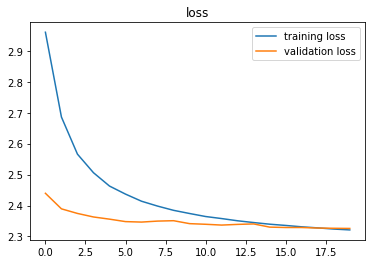

Plotting metrics...


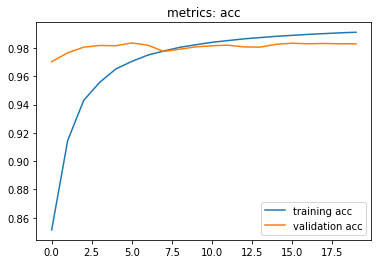

train {'acc': 0.9999818}
test {'acc': 0.9806}

Training student with temperature = 4 , coef = 16 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5503387695030497350
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 16215977871164074939
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 42.55225 , acc = 0.15 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.03778600000032384
loss_train : 0.022666999999728432
metric batch : 0.021467000000029657
whole : 0.08232300000008763
display_whole : 0.04451699999981429
Epoch 1 , step 100 , loss= 34.73544 , acc = 0.62 
t_cost <class 'dict'> 
get_batch : 1.0999999631167157e-05
train_op : 0.007724000000052911
loss_train : 0.009073000000171305
metric batch : 0.008542000000034022
whole : 0.025609999999687716
display_whole : 0.01786500000025626
Epo

Epoch 5 , step 100 , loss= 33.842964 , acc = 0.77 
t_cost <class 'dict'> 
get_batch : 9.999999747378752e-06
train_op : 0.009525999999823398
loss_train : 0.003548000000137108
metric batch : 0.004922000000078697
whole : 0.018457000000125845
display_whole : 0.008910999999898195
Epoch 5 , step 200 , loss= 33.957226 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.007865999999921769
loss_train : 0.006139000000075612
metric batch : 0.01023399999985486
whole : 0.02453399999967587
display_whole : 0.01665000000002692
Epoch 5 , step 300 , loss= 34.005054 , acc = 0.73 
t_cost <class 'dict'> 
get_batch : 9.000000318337698e-06
train_op : 0.008053999999901862
loss_train : 0.013054000000011001
metric batch : 0.008477000000311818
whole : 0.029901999999765394
display_whole : 0.021829000000252563
Epoch 5 , step 400 , loss= 33.7514 , acc = 0.59 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.010881000000154017
loss_train : 0.004434999999830325
metr

Epoch 9 , step 300 , loss= 33.492287 , acc = 0.72 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.008779999999660504
loss_train : 0.00987699999996039
metric batch : 0.008819000000130472
whole : 0.027780000000348082
display_whole : 0.018986000000040804
Epoch 9 , step 400 , loss= 33.57031 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.01079699999991135
loss_train : 0.0057809999998426065
metric batch : 0.00917699999990873
whole : 0.026208000000224274
display_whole : 0.015396000000237109
Epoch 9 , step 500 , loss= 33.7582 , acc = 0.76 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.006253000000015163
loss_train : 0.008323999999902298
metric batch : 0.002822000000378466
whole : 0.017758999999841762
display_whole : 0.011489999999866995
Epoch 9 , step 549 , loss= 34.0068 val_loss= 33.940525 , acc = 0.74 val acc = 0.6656 
Epoch 9 finished, loss= 34.08254 t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
t

Epoch 13 , step 500 , loss= 33.63008 , acc = 0.69 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.0047920000001795415
loss_train : 0.02129300000024159
metric batch : 0.009481999999934487
whole : 0.03586100000029546
display_whole : 0.031057000000146218
Epoch 13 , step 549 , loss= 33.603626 val_loss= 33.923637 , acc = 0.74 val acc = 0.679 
Epoch 13 finished, loss= 33.964767 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.010095000000092114
loss_train : 0.016383000000132597
loss_val : 0.03182100000003629
metric_val : 0.02002600000014354
metric batch : 0.00741699999980483
whole : 0.08659399999987727
display_whole : 0.07648400000016409
Epoch 14 , step 50 , loss= 34.068604 , acc = 0.68 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.012013000000024476
loss_train : 0.006014999999933934
metric batch : 0.007145999999920605
whole : 0.025529000000005908
display_whole : 0.013470999999753985
Epoch 14 , step 150 , loss= 34.063374 , 

Epoch 18 , step 50 , loss= 33.891155 , acc = 0.74 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.012884999999641877
loss_train : 0.008115000000088912
metric batch : 0.004786999999851105
whole : 0.026167999999870517
display_whole : 0.013271000000258937
Epoch 18 , step 150 , loss= 33.754883 , acc = 0.85 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.012131999999837717
loss_train : 0.00757000000021435
metric batch : 0.008727999999791791
whole : 0.028790000000299187
display_whole : 0.01664600000003702
Epoch 18 , step 250 , loss= 33.623302 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.010471999999936088
loss_train : 0.011872999999923195
metric batch : 0.0046040000001994486
whole : 0.027318999999806692
display_whole : 0.016798999999991793
Epoch 18 , step 350 , loss= 33.475826 , acc = 0.73 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.003812999999809108
loss_train : 0.0100349999997888

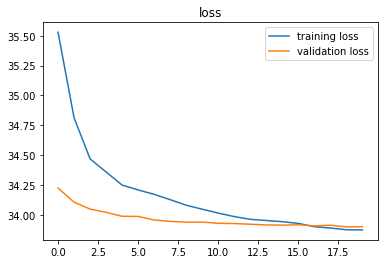

Plotting metrics...


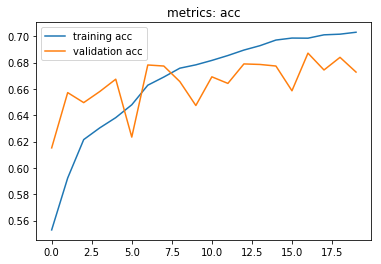

train {'acc': 0.72312725}
test {'acc': 0.6753}

Training student with temperature = 8 , coef = 0.015625 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12686664417742673644
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 9673886976291253515
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 2.5308514 , acc = 0.31 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.04658599999993385
loss_train : 0.041502999999920576
metric batch : 0.026854000000184897
whole : 0.11531700000023193
display_whole : 0.06870400000025256
Epoch 1 , step 100 , loss= 0.18553281 , acc = 0.94 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.005161000000043714
loss_train : 0.003517000000101689
metric batch : 0.0028119999997215928
whole : 0.012138000000049942
display_whole : 0.00696500000

Epoch 5 , step 100 , loss= 0.04693847 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.010039999999662541
loss_train : 0.007790999999997439
metric batch : 0.008184000000255764
whole : 0.026358999999956723
display_whole : 0.016304999999647407
Epoch 5 , step 200 , loss= 0.04884371 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009345999999823107
loss_train : 0.007557000000360858
metric batch : 0.008228000000144675
whole : 0.02544899999975314
display_whole : 0.01609099999996033
Epoch 5 , step 300 , loss= 0.05491447 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.01156700000001365
loss_train : 0.006707000000005792
metric batch : 0.00783800000044721
whole : 0.0264830000000984
display_whole : 0.014901000000008935
Epoch 5 , step 400 , loss= 0.043590933 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011465000000043801
loss_train : 0.006142000000181724
met

Epoch 9 , step 300 , loss= 0.042882044 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.999999863590347e-06
train_op : 0.009168999999928928
loss_train : 0.006914000000051601
metric batch : 0.002919000000019878
whole : 0.019296999999824038
display_whole : 0.010113999999703083
Epoch 9 , step 400 , loss= 0.043583333 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.000000434549293e-06
train_op : 0.011797000000115077
loss_train : 0.007189999999809515
metric batch : 0.009325999999873602
whole : 0.028588000000127067
display_whole : 0.016777999999703752
Epoch 9 , step 500 , loss= 0.044497542 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.005722999999761669
loss_train : 0.006022999999913736
metric batch : 0.004512999999860767
whole : 0.01658999999972366
display_whole : 0.010855999999876076
Epoch 9 , step 549 , loss= 0.045195922 val_loss= 0.14112511 , acc = 1.0 val acc = 0.9758 
Epoch 9 finished, loss= 0.10438457 t_cost <class 'dict'> 
get_batch : 5.00000032

Epoch 13 , step 500 , loss= 0.04712911 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.012764999999944848
loss_train : 0.006781999999930122
metric batch : 0.002191000000038912
whole : 0.022455999999692722
display_whole : 0.009677999999894382
Epoch 13 , step 549 , loss= 0.04471466 val_loss= 0.13631327 , acc = 1.0 val acc = 0.9776 
Epoch 13 finished, loss= 0.085584275 t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.012567000000217377
loss_train : 0.006513999999697262
loss_val : 0.029686999999739783
metric_val : 0.02364400000033129
metric batch : 0.008207000000311382
whole : 0.08169099999986429
display_whole : 0.06910199999992983
Epoch 14 , step 50 , loss= 0.042421553 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.006213999999999942
loss_train : 0.00355600000011691
metric batch : 0.009923000000071625
whole : 0.020085000000108266
display_whole : 0.013853999999810185
Epoch 14 , step 150 , loss= 0.04

Epoch 18 , step 50 , loss= 0.038484383 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.010249999999814463
loss_train : 0.006053999999949156
metric batch : 0.00413799999978437
whole : 0.020793000000139727
display_whole : 0.01053200000023935
Epoch 18 , step 150 , loss= 0.03890745 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.010181999999986147
loss_train : 0.0067790000002787565
metric batch : 0.0016120000000228174
whole : 0.018984999999702268
display_whole : 0.008790000000317377
Epoch 18 , step 250 , loss= 0.038747035 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.008855000000039581
loss_train : 0.006237000000055559
metric batch : 0.008426000000326894
whole : 0.023837999999614112
display_whole : 0.014972999999827152
Epoch 18 , step 350 , loss= 0.038326 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.00953899999967689
loss_train : 0.008481000000301

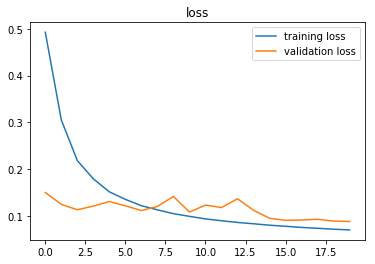

Plotting metrics...


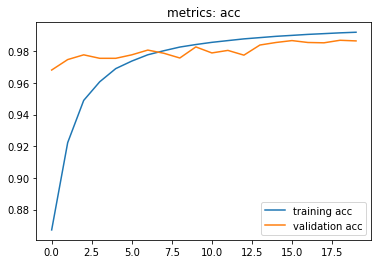

train {'acc': 1.0}
test {'acc': 0.9856}

Training student with temperature = 8 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15380094533795630825
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 13956312204967073119
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 4.3258505 , acc = 0.46 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.0470909999999094
loss_train : 0.02853499999991982
metric batch : 0.020749000000250817
whole : 0.09665300000006027
display_whole : 0.04954199999974662
Epoch 1 , step 100 , loss= 2.5361567 , acc = 0.94 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.006954999999834399
loss_train : 0.0030940000001464796
metric batch : 0.008945000000039727
whole : 0.019267000000127155
display_whole : 0.012298000000100728
Epoch 1 

Epoch 5 , step 100 , loss= 2.3117814 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.999999863590347e-06
train_op : 0.004981999999927211
loss_train : 0.010824999999840657
metric batch : 0.004885999999714841
whole : 0.02119200000015553
display_whole : 0.01619200000004639
Epoch 5 , step 200 , loss= 2.3090847 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.0037290000000211876
loss_train : 0.009263999999802763
metric batch : 0.008886999999958789
whole : 0.02227100000027349
display_whole : 0.01852999999982785
Epoch 5 , step 300 , loss= 2.3095882 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.004304000000047381
loss_train : 0.011015999999926862
metric batch : 0.007514999999784777
whole : 0.023118000000067696
display_whole : 0.018804000000272936
Epoch 5 , step 400 , loss= 2.3096473 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.004034999999930733
loss_train : 0.008004999999684514
metri

Epoch 9 , step 300 , loss= 2.3081393 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.00881600000002436
loss_train : 0.01905799999985902
metric batch : 0.0071170000001075095
whole : 0.03528099999994083
display_whole : 0.026450999999724445
Epoch 9 , step 400 , loss= 2.3071866 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009402000000136468
loss_train : 0.012305999999625783
metric batch : 0.008713000000170723
whole : 0.03072199999996883
display_whole : 0.021308999999746447
Epoch 9 , step 500 , loss= 2.3416905 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.009324000000106025
loss_train : 0.017621999999846594
metric batch : 0.008860999999797059
whole : 0.03611499999988155
display_whole : 0.02677899999980582
Epoch 9 , step 549 , loss= 2.3444567 val_loss= 2.4205773 , acc = 1.0 val acc = 0.9734 
Epoch 9 finished, loss= 2.369576 t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
tra

Epoch 13 , step 500 , loss= 2.3065493 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.0103039999999055
loss_train : 0.008589000000029046
metric batch : 0.0061670000000049185
whole : 0.025340000000142027
display_whole : 0.015022999999928288
Epoch 13 , step 549 , loss= 2.3000312 val_loss= 2.3534124 , acc = 1.0 val acc = 0.9856 
Epoch 13 finished, loss= 2.3507051 t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.011156000000028143
loss_train : 0.01470999999992273
loss_val : 0.03237200000012308
metric_val : 0.025952999999844906
metric batch : 0.004069000000072265
whole : 0.08883400000013353
display_whole : 0.07766300000002957
Epoch 14 , step 50 , loss= 2.3024142 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.011437000000114494
loss_train : 0.006304000000000087
metric batch : 0.006524000000354135
whole : 0.02483299999994415
display_whole : 0.013382999999976164
Epoch 14 , step 150 , loss= 2.2981536 , a

Epoch 18 , step 50 , loss= 2.32875 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.010174000000006345
loss_train : 0.008119999999962602
metric batch : 0.004343000000062602
whole : 0.02295400000002701
display_whole : 0.01276899999993475
Epoch 18 , step 150 , loss= 2.324808 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011727000000064436
loss_train : 0.006149000000277738
metric batch : 0.008544999999685388
whole : 0.02683999999999287
display_whole : 0.015100000000074942
Epoch 18 , step 250 , loss= 2.313755 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009904999999889696
loss_train : 0.005043000000114262
metric batch : 0.0015670000002501183
whole : 0.016897000000426488
display_whole : 0.006979000000228552
Epoch 18 , step 350 , loss= 2.3178246 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.009120000000166328
loss_train : 0.007479999999759457
metri

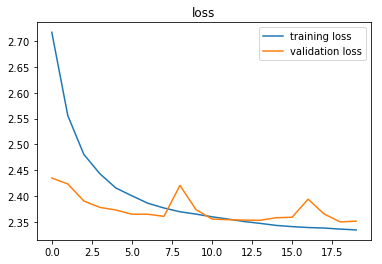

Plotting metrics...


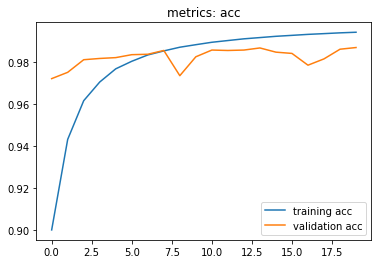

train {'acc': 1.0}
test {'acc': 0.9842}

Training student with temperature = 8 , coef = 64 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3887175893735003866
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3112632320
locality {
  bus_id: 1
}
incarnation: 11214042973878672626
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 153.68875 , acc = 0.12 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.047334000000319065
loss_train : 0.02907199999981458
metric batch : 0.02356899999995221
whole : 0.1003179999997883
display_whole : 0.052963999999974476
Epoch 1 , step 100 , loss= 144.8169 , acc = 0.54 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.010956000000078348
loss_train : 0.008594999999786523
metric batch : 0.0035530000000107975
whole : 0.023637000000235275
display_whole : 0.012673999999606167
Epoch 1 

Epoch 5 , step 100 , loss= 143.39925 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.011093000000073516
loss_train : 0.008135999999922205
metric batch : 0.00427399999989575
whole : 0.023791999999957625
display_whole : 0.012687999999798194
Epoch 5 , step 200 , loss= 143.72906 , acc = 0.69 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.010383000000274478
loss_train : 0.008034999999836145
metric batch : 0.006188999999722
whole : 0.025000999999974738
display_whole : 0.01460399999996298
Epoch 5 , step 300 , loss= 142.93703 , acc = 0.67 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011244000000260712
loss_train : 0.010736000000179047
metric batch : 0.00412400000004709
whole : 0.026886999999987893
display_whole : 0.015632999999979802
Epoch 5 , step 400 , loss= 143.35783 , acc = 0.65 
t_cost <class 'dict'> 
get_batch : 9.000000318337698e-06
train_op : 0.010608000000047468
loss_train : 0.012299999999868305
metr

Epoch 9 , step 300 , loss= 143.14417 , acc = 0.74 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.008229999999912252
loss_train : 0.007690999999795167
metric batch : 0.005575000000135333
whole : 0.0221480000000156
display_whole : 0.013909999999668798
Epoch 9 , step 400 , loss= 142.9558 , acc = 0.73 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009570000000167056
loss_train : 0.007506999999804975
metric batch : 0.003531000000293716
whole : 0.020899000000099477
display_whole : 0.011320999999952619
Epoch 9 , step 500 , loss= 142.92804 , acc = 0.69 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.008769999999913125
loss_train : 0.00721800000019357
metric batch : 0.008539999999811698
whole : 0.024910000000090804
display_whole : 0.016124000000218075
Epoch 9 , step 549 , loss= 142.76215 val_loss= 143.46994 , acc = 0.68 val acc = 0.656 
Epoch 9 finished, loss= 143.5327 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06

Epoch 13 , step 500 , loss= 143.52094 , acc = 0.74 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.008910999999898195
loss_train : 0.003962000000228727
metric batch : 0.006503000000066095
whole : 0.01973900000029971
display_whole : 0.010815000000093278
Epoch 13 , step 549 , loss= 143.2868 val_loss= 143.44092 , acc = 0.75 val acc = 0.6384 
Epoch 13 finished, loss= 143.42903 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.00796200000013414
loss_train : 0.0053700000003118475
loss_val : 0.033086000000366766
metric_val : 0.024932999999691674
metric batch : 0.0019669999996949628
whole : 0.07416199999988748
display_whole : 0.0661830000003647
Epoch 14 , step 50 , loss= 142.52771 , acc = 0.73 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.007599000000027445
loss_train : 0.00825699999995777
metric batch : 0.006276999999954569
whole : 0.02250400000002628
display_whole : 0.014889000000039232
Epoch 14 , step 150 , loss= 143.00987 

Epoch 18 , step 50 , loss= 142.63487 , acc = 0.67 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.010209999999915453
loss_train : 0.020300000000133878
metric batch : 0.0056679999997868435
whole : 0.0364409999997406
display_whole : 0.026221999999961554
Epoch 18 , step 150 , loss= 143.15579 , acc = 0.67 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.009117000000060216
loss_train : 0.0028330000000096334
metric batch : 0.006395000000338769
whole : 0.01868400000012116
display_whole : 0.009548999999879015
Epoch 18 , step 250 , loss= 143.87122 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.010654000000158703
loss_train : 0.004543000000012398
metric batch : 0.00916300000017145
whole : 0.02461700000003475
display_whole : 0.013949000000138767
Epoch 18 , step 350 , loss= 143.4219 , acc = 0.69 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.007970000000113941
loss_train : 0.013938000000052853


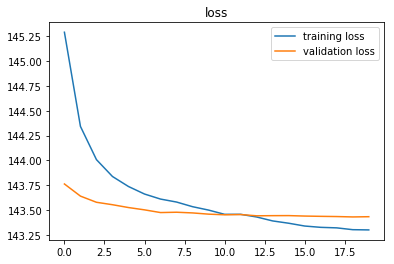

Plotting metrics...


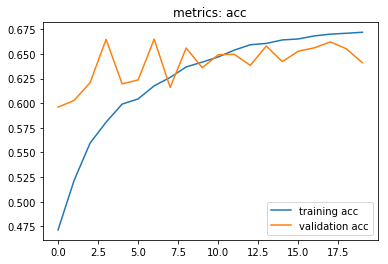

train {'acc': 0.6810909}
test {'acc': 0.6307}

Training student with temperature = 16 , coef = 0.00390625 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3393112025391107711
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 2330256557414129643
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 2.7227292 , acc = 0.32 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.04165199999988545
loss_train : 0.043607000000065455
metric batch : 0.020643000000291067
whole : 0.10625499999969179
display_whole : 0.06458400000019537
Epoch 1 , step 100 , loss= 0.33647457 , acc = 0.94 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.005673999999999069
loss_train : 0.011331000000154745
metric batch : 0.004018000000087341
whole : 0.021427999999559688
display_whole : 0.01574100000

Epoch 5 , step 0 , loss= 0.026105944 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 0.007326999999804684
train_op : 0.01191000000017084
loss_train : 0.006519999999909487
metric batch : 0.008346999999957916
whole : 0.03442499999982829
display_whole : 0.015163999999913358
Epoch 5 , step 100 , loss= 0.0179068 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.00700200000028417
loss_train : 0.013609999999971478
metric batch : 0.005091999999876862
whole : 0.026120999999875494
display_whole : 0.019100999999864143
Epoch 5 , step 200 , loss= 0.015229411 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.999999863590347e-06
train_op : 0.011563999999907537
loss_train : 0.008738999999877706
metric batch : 0.006033999999999651
whole : 0.026648999999906664
display_whole : 0.015066999999817199
Epoch 5 , step 300 , loss= 0.012470662 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.0052959999998165586
loss_train : 0.0029850000000806176


Epoch 9 , step 200 , loss= 0.0129637 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.009422999999969761
loss_train : 0.0074930000000676955
metric batch : 0.007291999999779364
whole : 0.024609999999938736
display_whole : 0.015174000000115484
Epoch 9 , step 300 , loss= 0.013329021 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.008167999999841413
loss_train : 0.026428000000123575
metric batch : 0.009409000000232481
whole : 0.04433900000003632
display_whole : 0.03615600000011909
Epoch 9 , step 400 , loss= 0.011643124 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011790000000019063
loss_train : 0.005988000000343163
metric batch : 0.0071250000000873115
whole : 0.02543500000001586
display_whole : 0.013637000000016997
Epoch 9 , step 500 , loss= 0.010215576 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.01190500000029715
loss_train : 0.01844399999981760

Epoch 13 , step 400 , loss= 0.011689351 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.010939000000234955
loss_train : 0.007552000000032422
metric batch : 0.001896000000215281
whole : 0.020709000000351807
display_whole : 0.009761000000253262
Epoch 13 , step 500 , loss= 0.011855603 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011290999999800988
loss_train : 0.005783000000064931
metric batch : 0.008526000000074418
whole : 0.02599000000009255
display_whole : 0.014681999999993423
Epoch 13 , step 549 , loss= 0.010989291 val_loss= 0.1137023 , acc = 1.0 val acc = 0.9794 
Epoch 13 finished, loss= 0.06038188 t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.00977599999987433
loss_train : 0.004584999999678985
loss_val : 0.03661600000032195
metric_val : 0.023959000000104425
metric batch : 0.004525999999714259
whole : 0.08026900000004389
display_whole : 0.070477999999639
Epoch 14 , step 50 , loss= 0.01261

Epoch 17 , step 549 , loss= 0.010916282 val_loss= 0.0850818 , acc = 1.0 val acc = 0.9836 
Epoch 17 finished, loss= 0.049320567 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.011641000000054191
loss_train : 0.008264000000053784
loss_val : 0.03567699999985052
metric_val : 0.024090000000342116
metric batch : 0.004073000000062166
whole : 0.08448700000008103
display_whole : 0.07283399999960238
Epoch 18 , step 50 , loss= 0.010372842 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.0056710000003477035
loss_train : 0.004081999999925756
metric batch : 0.007427000000006956
whole : 0.017507000000023254
display_whole : 0.011827999999695749
Epoch 18 , step 150 , loss= 0.010401601 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.003470999999990454
loss_train : 0.010029000000031374
metric batch : 0.009237000000211992
whole : 0.023149000000103115
display_whole : 0.019662000000153057
Epoch 18 , step 250 , loss= 0

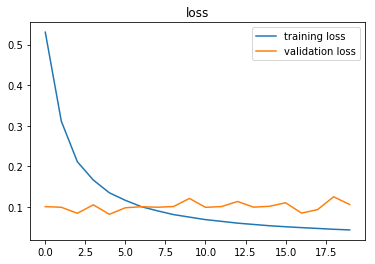

Plotting metrics...


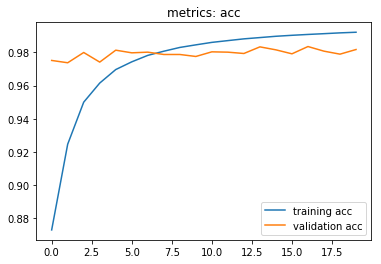

train {'acc': 0.99790907}
test {'acc': 0.9794}

Training student with temperature = 16 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8650056571664525872
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 9740053896635410613
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 5.6189847 , acc = 0.3 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.04873700000007375
loss_train : 0.03950299999996787
metric batch : 0.027235000000018772
whole : 0.1157469999998284
display_whole : 0.06699200000002747
Epoch 1 , step 100 , loss= 2.5478833 , acc = 0.92 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.008993000000373286
loss_train : 0.01650900000004185
metric batch : 0.008813000000372995
whole : 0.03467799999998533
display_whole : 0.025672000000213302
Epoch 

Epoch 5 , step 100 , loss= 2.3203413 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.011559999999917636
loss_train : 0.01585399999976289
metric batch : 0.002816000000166241
whole : 0.030573000000003958
display_whole : 0.018999999999778083
Epoch 5 , step 200 , loss= 2.3225436 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 1.5999999959603883e-05
train_op : 0.01044499999989057
loss_train : 0.007789999999658903
metric batch : 0.008444999999937863
whole : 0.0270410000002812
display_whole : 0.016573999999764055
Epoch 5 , step 300 , loss= 2.3175619 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.010130000000117434
loss_train : 0.006836999999904947
metric batch : 0.006658000000243192
whole : 0.024030999999922642
display_whole : 0.013889000000290253
Epoch 5 , step 400 , loss= 2.3207684 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009777000000212865
loss_train : 0.007359000000178639
metri

Epoch 9 , step 300 , loss= 2.3104148 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.008902999999918393
loss_train : 0.012034999999741558
metric batch : 0.006424000000151864
whole : 0.02773299999989831
display_whole : 0.018818999999894004
Epoch 9 , step 400 , loss= 2.3095226 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.010729000000083033
loss_train : 0.010028000000147586
metric batch : 0.004426999999850523
whole : 0.02546100000017759
display_whole : 0.014720000000124855
Epoch 9 , step 500 , loss= 2.3055093 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.00997800000004645
loss_train : 0.005114000000048691
metric batch : 0.0016120000000228174
whole : 0.01713900000004287
display_whole : 0.007149000000026717
Epoch 9 , step 549 , loss= 2.3082488 val_loss= 2.357646 , acc = 1.0 val acc = 0.9882 
Epoch 9 finished, loss= 2.3927126 t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
t

Epoch 13 , step 500 , loss= 2.3068004 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.0092690000001312
loss_train : 0.002395999999862397
metric batch : 0.005661000000145577
whole : 0.017575000000306318
display_whole : 0.008292999999866879
Epoch 13 , step 549 , loss= 2.3139408 val_loss= 2.382199 , acc = 1.0 val acc = 0.981 
Epoch 13 finished, loss= 2.3666263 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.01073099999985061
loss_train : 0.018018000000211032
loss_val : 0.030574000000342494
metric_val : 0.023819000000003143
metric batch : 0.0050590000000738655
whole : 0.08878400000003239
display_whole : 0.07803800000010597
Epoch 14 , step 50 , loss= 2.3672128 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.005058000000190077
loss_train : 0.006318000000192114
metric batch : 0.0042480000001887674
whole : 0.01613099999985934
display_whole : 0.011061000000154309
Epoch 14 , step 150 , loss= 2.3437283 , a

Epoch 18 , step 50 , loss= 2.308291 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.012286000000131025
loss_train : 0.013891999999941618
metric batch : 0.003293999999641528
whole : 0.029777999999623717
display_whole : 0.017475000000104046
Epoch 18 , step 150 , loss= 2.306845 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.010698000000047614
loss_train : 0.005801000000246859
metric batch : 0.007033000000319589
whole : 0.024024999999710417
display_whole : 0.013315000000147847
Epoch 18 , step 250 , loss= 2.3078778 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009625000000141881
loss_train : 0.0026050000001305307
metric batch : 0.004306000000269705
whole : 0.016939999999976862
display_whole : 0.007298999999875377
Epoch 18 , step 350 , loss= 2.307266 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.011406000000079075
loss_train : 0.008504999999786378
m

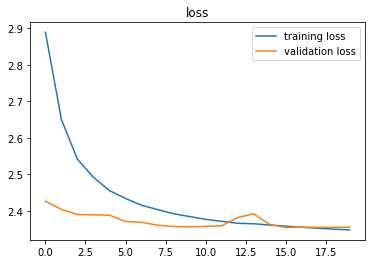

Plotting metrics...


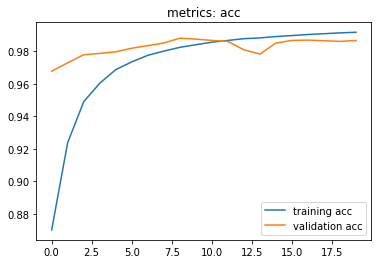

train {'acc': 1.0}
test {'acc': 0.9859}

Training student with temperature = 16 , coef = 256 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7660610703815063157
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 8894130940107491127
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 594.9356 , acc = 0.2 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.05280499999980748
loss_train : 0.035577000000103
metric batch : 0.02556300000014744
whole : 0.11421199999995224
display_whole : 0.061388000000079046
Epoch 1 , step 100 , loss= 586.14874 , acc = 0.54 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009708999999929802
loss_train : 0.014750999999705527
metric batch : 0.006744999999682477
whole : 0.03158100000018749
display_whole : 0.021856999999727122
Epoch 1 , st

Epoch 5 , step 100 , loss= 585.2883 , acc = 0.76 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.011649999999917782
loss_train : 0.0073010000000977016
metric batch : 0.007145000000036816
whole : 0.02641799999992145
display_whole : 0.014758000000256288
Epoch 5 , step 200 , loss= 584.80615 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.00955100000010134
loss_train : 0.007611999999880936
metric batch : 0.007600000000365981
whole : 0.02507000000014159
display_whole : 0.015503999999964435
Epoch 5 , step 300 , loss= 584.9042 , acc = 0.75 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.009447000000363914
loss_train : 0.007818000000042957
metric batch : 0.004283999999643129
whole : 0.02195800000026793
display_whole : 0.012499999999818101
Epoch 5 , step 400 , loss= 584.9418 , acc = 0.79 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.010238000000299508
loss_train : 0.018870000000333675
metr

Epoch 9 , step 300 , loss= 584.9402 , acc = 0.76 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.012364000000161468
loss_train : 0.006031999999777327
metric batch : 0.004990999999790802
whole : 0.023725000000013097
display_whole : 0.011349999999765714
Epoch 9 , step 400 , loss= 584.7755 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.004961000000093918
loss_train : 0.009944999999788706
metric batch : 0.009234999999989668
whole : 0.024433999999928346
display_whole : 0.01946300000008705
Epoch 9 , step 500 , loss= 585.35645 , acc = 0.79 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.011407999999846652
loss_train : 0.012193000000024767
metric batch : 0.008825999999771739
whole : 0.03271499999982552
display_whole : 0.021295000000009168
Epoch 9 , step 549 , loss= 584.7272 val_loss= 585.3496 , acc = 0.7 val acc = 0.7446 
Epoch 9 finished, loss= 585.3876 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
tr

Epoch 13 , step 500 , loss= 585.01746 , acc = 0.73 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.010166999999910331
loss_train : 0.01216500000009546
metric batch : 0.004378999999971711
whole : 0.026957000000038533
display_whole : 0.016775000000052387
Epoch 13 , step 549 , loss= 584.8637 val_loss= 585.3332 , acc = 0.83 val acc = 0.7244 
Epoch 13 finished, loss= 585.3075 t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.007885999999871274
loss_train : 0.021345999999994092
loss_val : 0.05417699999998149
metric_val : 0.022065000000111468
metric batch : 0.007967000000007829
whole : 0.11414500000000771
display_whole : 0.1062459999998282
Epoch 14 , step 50 , loss= 584.69586 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.01089799999999741
loss_train : 0.010862000000088301
metric batch : 0.0046950000000833825
whole : 0.02671600000030594
display_whole : 0.01580100000001039
Epoch 14 , step 150 , loss= 584.89886 , ac

Epoch 18 , step 50 , loss= 584.70917 , acc = 0.8 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.010249999999814463
loss_train : 0.005717999999887979
metric batch : 0.007929000000331143
whole : 0.024175999999897613
display_whole : 0.013910000000123546
Epoch 18 , step 150 , loss= 585.1653 , acc = 0.78 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009501999999883992
loss_train : 0.00753900000017893
metric batch : 0.0025319999999737774
whole : 0.01998700000012832
display_whole : 0.010474000000158412
Epoch 18 , step 250 , loss= 585.246 , acc = 0.86 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.01020299999981944
loss_train : 0.007532000000082917
metric batch : 0.0035450000000309956
whole : 0.021626000000196655
display_whole : 0.011413000000175089
Epoch 18 , step 350 , loss= 585.389 , acc = 0.81 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.012030999999751657
loss_train : 0.004527000000052794
me

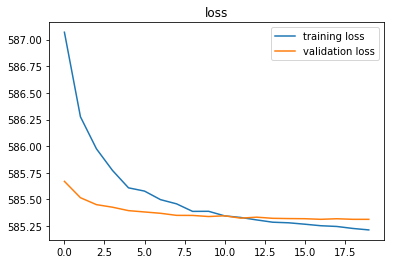

Plotting metrics...


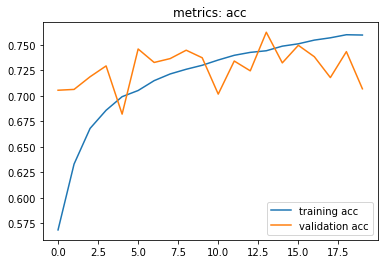

train {'acc': 0.7589818}
test {'acc': 0.6928}

Training student with temperature = 32 , coef = 0.0009765625 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 422206998540621720
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 5501827992927419792
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 3.3215942 , acc = 0.23 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.06300300000020798
loss_train : 0.03735599999981787
metric batch : 0.033699000000069645
whole : 0.13438900000028298
display_whole : 0.07136399999990317
Epoch 1 , step 100 , loss= 0.28094003 , acc = 0.92 
t_cost <class 'dict'> 
get_batch : 8.999999863590347e-06
train_op : 0.011403999999856751
loss_train : 0.011440000000220607
metric batch : 0.004457000000002154
whole : 0.027947999999923923
display_whole : 0.01652899999

Epoch 5 , step 100 , loss= 0.008936311 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009272000000237313
loss_train : 0.004400999999688793
metric batch : 0.004448000000138563
whole : 0.01848199999994904
display_whole : 0.009196999999858235
Epoch 5 , step 200 , loss= 0.01579776 , acc = 0.99 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.011234000000058586
loss_train : 0.011545999999725609
metric batch : 0.00878999999986263
whole : 0.031836999999995896
display_whole : 0.020587999999861495
Epoch 5 , step 300 , loss= 0.010395745 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.00739400000020396
loss_train : 0.007035000000087166
metric batch : 0.006589000000076339
whole : 0.021396999999979016
display_whole : 0.013990999999805354
Epoch 5 , step 400 , loss= 0.0053590965 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.010539000000335363
loss_train : 0.012732000000141

Epoch 9 , step 300 , loss= 0.0042512203 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.008345000000190339
loss_train : 0.02819499999986874
metric batch : 0.0016749999999774445
whole : 0.03856100000029983
display_whole : 0.03020399999968504
Epoch 9 , step 400 , loss= 0.0070486 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.007094000000051892
loss_train : 0.004220000000259461
metric batch : 0.00887399999965055
whole : 0.020469999999932043
display_whole : 0.013363000000026659
Epoch 9 , step 500 , loss= 0.0057030357 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.008572999999614694
loss_train : 0.002951999999822874
metric batch : 0.004152000000431144
whole : 0.0159590000002936
display_whole : 0.007376000000022032
Epoch 9 , step 549 , loss= 0.011289067 val_loss= 0.11484879 , acc = 1.0 val acc = 0.9744 
Epoch 9 finished, loss= 0.08203442 t_cost <class 'dict'> 
get_batch : 5.999999757477

Epoch 13 , step 500 , loss= 0.0030671135 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.004570999999941705
loss_train : 0.002490000000307191
metric batch : 0.0014860000001135631
whole : 0.009045000000241998
display_whole : 0.0044580000003406894
Epoch 13 , step 549 , loss= 0.0040154923 val_loss= 0.08972154 , acc = 1.0 val acc = 0.9818 
Epoch 13 finished, loss= 0.058420256 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.003576000000066415
loss_train : 0.018768999999792868
loss_val : 0.024042000000008557
metric_val : 0.021145000000160508
metric batch : 0.0013790000002700253
whole : 0.06958499999973355
display_whole : 0.06599499999992986
Epoch 14 , step 50 , loss= 0.0027914748 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.000000106112566e-06
train_op : 0.0028760000000147556
loss_train : 0.0025160000000141736
metric batch : 0.0015610000000378932
whole : 0.007383000000118045
display_whole : 0.004500000000007276
Epoch 14 , step 150

Epoch 18 , step 50 , loss= 0.003109442 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 1.5000000075815478e-05
train_op : 0.010506999999961408
loss_train : 0.0028250000000298314
metric batch : 0.007236999999804539
whole : 0.020980000000236032
display_whole : 0.010451000000102795
Epoch 18 , step 150 , loss= 0.005936935 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.009813000000121974
loss_train : 0.016928999999890948
metric batch : 0.008444999999937863
whole : 0.03570900000022448
display_whole : 0.025881999999910477
Epoch 18 , step 250 , loss= 0.003649891 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.009751999999934924
loss_train : 0.008529000000180531
metric batch : 0.0044420000003810856
whole : 0.023055999999996857
display_whole : 0.013293999999859807
Epoch 18 , step 350 , loss= 0.0031967014 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.010085999999773776
loss_train : 0.0081150

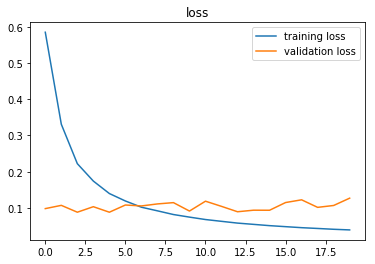

Plotting metrics...


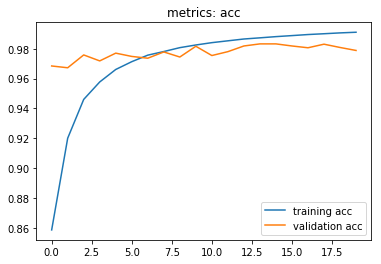

train {'acc': 0.9978909}
test {'acc': 0.9807}

Training student with temperature = 32 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17430095308741478718
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 3396161280486229832
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 6.7165236 , acc = 0.21 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.06000399999993533
loss_train : 0.04599199999984194
metric batch : 0.037550999999893975
whole : 0.14411400000017238
display_whole : 0.08408899999994901
Epoch 1 , step 100 , loss= 2.5930438 , acc = 0.92 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011521999999786203
loss_train : 0.008201999999982945
metric batch : 0.0042789999997694395
whole : 0.02434499999981199
display_whole : 0.012809000000288506
Ep

Epoch 5 , step 100 , loss= 2.3096273 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.009610999999949854
loss_train : 0.014807000000018888
metric batch : 0.00409799999988536
whole : 0.02880300000015268
display_whole : 0.01918100000011691
Epoch 5 , step 200 , loss= 2.3151977 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.012630000000172004
loss_train : 0.007833000000118773
metric batch : 0.0067490000001271255
whole : 0.027501000000029308
display_whole : 0.014858000000003813
Epoch 5 , step 300 , loss= 2.3146334 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.004805000000033033
loss_train : 0.011766999999963446
metric batch : 0.007588999999825319
whole : 0.024530999999569758
display_whole : 0.019714999999905558
Epoch 5 , step 400 , loss= 2.3111396 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.008407000000261178
loss_train : 0.011004999999840948
metr

Epoch 9 , step 300 , loss= 2.3145025 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.010174999999890133
loss_train : 0.006362000000081025
metric batch : 0.008984000000054948
whole : 0.025952000000415865
display_whole : 0.01576500000010128
Epoch 9 , step 400 , loss= 2.3123531 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009069000000181404
loss_train : 0.0034740000000965665
metric batch : 0.002213000000210741
whole : 0.015240000000176224
display_whole : 0.006160999999792693
Epoch 9 , step 500 , loss= 2.3110476 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.01121499999999287
loss_train : 0.019962000000305125
metric batch : 0.002231000000392669
whole : 0.03368900000032227
display_whole : 0.02245900000025358
Epoch 9 , step 549 , loss= 2.3166778 val_loss= 2.400628 , acc = 1.0 val acc = 0.9778 
Epoch 9 finished, loss= 2.407417 t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
tr

Epoch 13 , step 500 , loss= 2.3038464 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.012036999999963882
loss_train : 0.013018000000101893
metric batch : 0.008413999999902444
whole : 0.033820999999989
display_whole : 0.021772999999939202
Epoch 13 , step 549 , loss= 2.3051527 val_loss= 2.3545272 , acc = 1.0 val acc = 0.986 
Epoch 13 finished, loss= 2.376716 t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.01161099999990256
loss_train : 0.003509000000121887
loss_val : 0.027919999999994616
metric_val : 0.023662999999942258
metric batch : 0.008944000000155938
whole : 0.07637800000020434
display_whole : 0.06475300000010975
Epoch 14 , step 50 , loss= 2.3037815 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.01009299999986979
loss_train : 0.014581999999791151
metric batch : 0.0076730000000679865
whole : 0.03280700000004799
display_whole : 0.0227020000002085
Epoch 14 , step 150 , loss= 2.303751 , acc = 1

Epoch 18 , step 50 , loss= 2.3031054 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.004923999999846274
loss_train : 0.00955500000009124
metric batch : 0.007258000000092579
whole : 0.02221000000008644
display_whole : 0.017269000000396773
Epoch 18 , step 150 , loss= 2.3030746 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.013610999999855267
loss_train : 0.007892000000083499
metric batch : 0.00503500000013446
whole : 0.027145000000018626
display_whole : 0.013521000000309868
Epoch 18 , step 250 , loss= 2.3028154 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 8.999999863590347e-06
train_op : 0.012197000000014668
loss_train : 0.020934000000124797
metric batch : 0.0019420000003265159
whole : 0.03552499999977954
display_whole : 0.0233090000001539
Epoch 18 , step 350 , loss= 2.3032348 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009641999999985273
loss_train : 0.014909999999872525
metr

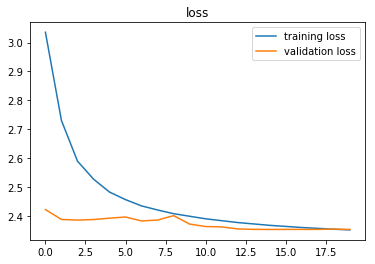

Plotting metrics...


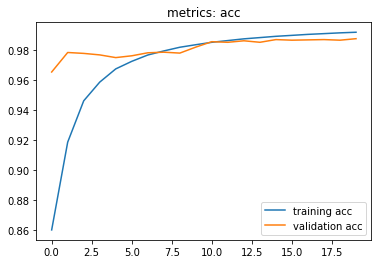

train {'acc': 1.0}
test {'acc': 0.9848}

Training student with temperature = 32 , coef = 1024 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15566322143993276124
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 13218931934254354254
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 2359.2078 , acc = 0.18 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.07371599999987666
loss_train : 0.04718400000001566
metric batch : 0.034777000000303815
whole : 0.15600299999960043
display_whole : 0.08226599999989048
Epoch 1 , step 100 , loss= 2351.2688 , acc = 0.54 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.004297999999835156
loss_train : 0.01866199999994933
metric batch : 0.006597000000056141
whole : 0.02991100000008373
display_whole : 0.02560300000004645
Epoch 1

Epoch 5 , step 100 , loss= 2350.9468 , acc = 0.72 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.004202000000077533
loss_train : 0.0026819999998224375
metric batch : 0.004977000000053522
whole : 0.012576000000080967
display_whole : 0.008360999999695196
Epoch 5 , step 200 , loss= 2350.1252 , acc = 0.66 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.011384000000361993
loss_train : 0.006732000000283733
metric batch : 0.007277000000158296
whole : 0.025776999999834516
display_whole : 0.014382000000296102
Epoch 5 , step 300 , loss= 2351.1902 , acc = 0.75 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.008343999999851803
loss_train : 0.0025080000000343716
metric batch : 0.0068400000000110595
whole : 0.018003000000135216
display_whole : 0.009645000000091386
Epoch 5 , step 400 , loss= 2350.7366 , acc = 0.61 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.009991000000354688
loss_train : 0.00688899999977

Epoch 9 , step 300 , loss= 2350.4404 , acc = 0.59 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.012261999999736872
loss_train : 0.008342999999968015
metric batch : 0.007040999999844644
whole : 0.027946000000156346
display_whole : 0.015671999999995023
Epoch 9 , step 400 , loss= 2350.494 , acc = 0.67 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011371000000053755
loss_train : 0.011242000000038388
metric batch : 0.009211000000050262
whole : 0.032153999999991356
display_whole : 0.02077000000008411
Epoch 9 , step 500 , loss= 2350.5146 , acc = 0.7 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.008299000000079104
loss_train : 0.01577599999973245
metric batch : 0.008968999999979133
whole : 0.033541999999670224
display_whole : 0.02522899999985384
Epoch 9 , step 549 , loss= 2350.779 val_loss= 2350.8394 , acc = 0.68 val acc = 0.6492 
Epoch 9 finished, loss= 2350.9675 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06

Epoch 13 , step 500 , loss= 2350.5264 , acc = 0.67 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.004494999999678839
loss_train : 0.0030560000000150467
metric batch : 0.0028210000000399305
whole : 0.010885000000143918
display_whole : 0.006378000000040629
Epoch 13 , step 549 , loss= 2350.6804 val_loss= 2350.811 , acc = 0.69 val acc = 0.638 
Epoch 13 finished, loss= 2350.8647 t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.005142999999861786
loss_train : 0.01621900000009191
loss_val : 0.03711799999973664
metric_val : 0.022638000000370084
metric batch : 0.002583000000413449
whole : 0.08438499999965643
display_whole : 0.07922800000005736
Epoch 14 , step 50 , loss= 2350.7837 , acc = 0.69 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.004489000000376109
loss_train : 0.008144999999785796
metric batch : 0.007404999999835127
whole : 0.020635000000311265
display_whole : 0.016133000000081665
Epoch 14 , step 150 , loss= 2350.807

Epoch 18 , step 50 , loss= 2350.0361 , acc = 0.71 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.011889000000337546
loss_train : 0.016856999999617983
metric batch : 0.008081999999831169
whole : 0.03742899999997462
display_whole : 0.025525999999899796
Epoch 18 , step 150 , loss= 2350.8752 , acc = 0.61 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011777000000165572
loss_train : 0.017982999999730964
metric batch : 0.007150999999794294
whole : 0.03734400000030291
display_whole : 0.025552999999945314
Epoch 18 , step 250 , loss= 2351.0325 , acc = 0.69 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.009900000000016007
loss_train : 0.004299000000173692
metric batch : 0.004368999999769585
whole : 0.018814999999904103
display_whole : 0.008906000000024505
Epoch 18 , step 350 , loss= 2350.8682 , acc = 0.74 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.010886999999911495
loss_train : 0.0137199999999211

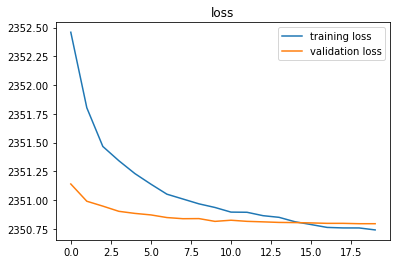

Plotting metrics...


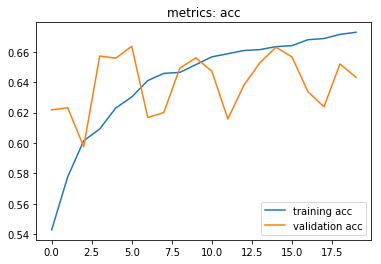

train {'acc': 0.6925273}
test {'acc': 0.63}

Training student with temperature = 64 , coef = 0.000244140625 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 986114987429318748
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 14459542481773066774
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 2.6408234 , acc = 0.42 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.05790999999999258
loss_train : 0.035112999999910244
metric batch : 0.03631199999972523
whole : 0.12978599999996732
display_whole : 0.07185699999990902
Epoch 1 , step 100 , loss= 0.17018194 , acc = 0.96 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.008687000000008993
loss_train : 0.00676900000007663
metric batch : 0.004174000000148226
whole : 0.020223999999871012
display_whole : 0.01152799999

Epoch 5 , step 0 , loss= 0.06438912 , acc = 0.99 
t_cost <class 'dict'> 
get_batch : 0.0053699999998571
train_op : 0.010737999999946624
loss_train : 0.00798499999973501
metric batch : 0.007525999999870692
whole : 0.032030000000304426
display_whole : 0.015904999999747815
Epoch 5 , step 100 , loss= 0.004660635 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.010420999999951164
loss_train : 0.0028250000000298314
metric batch : 0.006732000000283733
whole : 0.020216999999775
display_whole : 0.009786000000076456
Epoch 5 , step 200 , loss= 0.0074254223 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.004093000000011671
loss_train : 0.00785200000018449
metric batch : 0.00436600000011822
whole : 0.01659800000015821
display_whole : 0.012494999999944412
Epoch 5 , step 300 , loss= 0.007618754 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.004917000000205007
loss_train : 0.017007000000376138
metr

Epoch 9 , step 200 , loss= 0.002538234 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.0049359999998159765
loss_train : 0.008146000000124332
metric batch : 0.009047999999893364
whole : 0.02242900000010195
display_whole : 0.01748200000020006
Epoch 9 , step 300 , loss= 0.006447809 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.011029999999664142
loss_train : 0.008255000000190194
metric batch : 0.006458000000293396
whole : 0.026125000000320142
display_whole : 0.015085999999882915
Epoch 9 , step 400 , loss= 0.016489446 , acc = 0.99 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.012316000000282656
loss_train : 0.00835400000005393
metric batch : 0.00412400000004709
whole : 0.025051999999959662
display_whole : 0.012721999999939726
Epoch 9 , step 500 , loss= 0.0038240456 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.011913000000276952
loss_train : 0.00757399999974

Epoch 13 , step 400 , loss= 0.0012171364 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.00731599999971877
loss_train : 0.009149999999863212
metric batch : 0.008330999999998312
whole : 0.025129999999990105
display_whole : 0.01779499999975087
Epoch 13 , step 500 , loss= 0.0036573103 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.011149999999815918
loss_train : 0.002896999999848049
metric batch : 0.00485900000012407
whole : 0.019266999999672407
display_whole : 0.008106000000225322
Epoch 13 , step 549 , loss= 0.00091610954 val_loss= 0.13057308 , acc = 1.0 val acc = 0.9766 
Epoch 13 finished, loss= 0.05070245 t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.011066000000027998
loss_train : 0.0043530000002647284
loss_val : 0.029003000000102475
metric_val : 0.02360599999974511
metric batch : 0.006354000000101223
whole : 0.07503200000019206
display_whole : 0.06395500000007814
Epoch 14 , step 50 , loss= 

Epoch 17 , step 549 , loss= 0.021670962 val_loss= 0.115956604 , acc = 0.99 val acc = 0.9794 
Epoch 17 finished, loss= 0.03950522 t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.011290999999800988
loss_train : 0.0029460000000653963
loss_val : 0.056533999999828666
metric_val : 0.02322900000035588
metric batch : 0.0015410000000883883
whole : 0.09645300000011048
display_whole : 0.08514700000023367
Epoch 18 , step 50 , loss= 0.0008797778 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.004065999999966152
loss_train : 0.007435999999870546
metric batch : 0.004407999999784806
whole : 0.01627600000028906
display_whole : 0.012197000000014668
Epoch 18 , step 150 , loss= 0.0018436835 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.007013999999799125
loss_train : 0.010283000000072207
metric batch : 0.004320000000006985
whole : 0.02194499999995969
display_whole : 0.014914999999746215
Epoch 18 , step 250 , loss

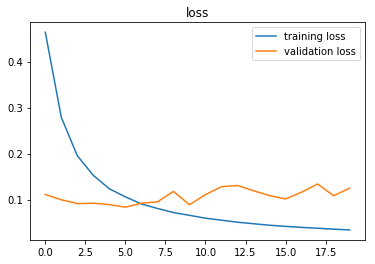

Plotting metrics...


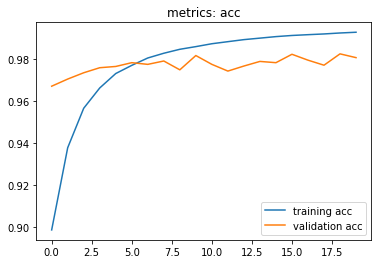

train {'acc': 0.99792725}
test {'acc': 0.981}

Training student with temperature = 64 , coef = 1 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1642982852036029741
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 8877115610229931971
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 4.5821185 , acc = 0.45 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.06188399999973626
loss_train : 0.05057500000020809
metric batch : 0.03392900000017107
whole : 0.1467779999998129
display_whole : 0.08487200000035955
Epoch 1 , step 100 , loss= 2.543794 , acc = 0.92 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.007548000000042521
loss_train : 0.004242999999860331
metric batch : 0.006276999999954569
whole : 0.018483999999716616
display_whole : 0.010922999999820604
Epoch 

Epoch 5 , step 100 , loss= 2.3086083 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.0030859999997119303
loss_train : 0.002577000000201224
metric batch : 0.0017189999998663552
whole : 0.007775999999921623
display_whole : 0.0046830000001136796
Epoch 5 , step 200 , loss= 2.3104138 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 3.999999989900971e-06
train_op : 0.003490999999939959
loss_train : 0.0027460000001156004
metric batch : 0.0016099999998004932
whole : 0.008161000000200147
display_whole : 0.004664000000047963
Epoch 5 , step 300 , loss= 2.313804 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.012118000000100437
loss_train : 0.016287999999804015
metric batch : 0.009784000000308879
whole : 0.03844600000002174
display_whole : 0.026345999999648484
Epoch 5 , step 400 , loss= 2.311452 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.009382000000186963
loss_train : 0.006545000000187429


Epoch 9 , step 300 , loss= 2.318967 , acc = 0.99 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.010110000000167929
loss_train : 0.012034000000312517
metric batch : 0.0028419999998732237
whole : 0.02540899999985413
display_whole : 0.015286000000287459
Epoch 9 , step 400 , loss= 2.30924 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011929000000236556
loss_train : 0.006650999999692431
metric batch : 0.008739999999761494
whole : 0.02782100000013088
display_whole : 0.015877999999702297
Epoch 9 , step 500 , loss= 2.3111982 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.008852999999817257
loss_train : 0.013389000000188389
metric batch : 0.007178999999723601
whole : 0.02977099999998245
display_whole : 0.02090600000019549
Epoch 9 , step 549 , loss= 2.3085551 val_loss= 2.375595 , acc = 1.0 val acc = 0.9802 
Epoch 9 finished, loss= 2.3704724 t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
tra

Epoch 13 , step 500 , loss= 2.309234 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.011864000000059605
loss_train : 0.019090999999662017
metric batch : 0.007506999999804975
whole : 0.0388850000003913
display_whole : 0.027005999999801134
Epoch 13 , step 549 , loss= 2.3063982 val_loss= 2.3648965 , acc = 1.0 val acc = 0.9866 
Epoch 13 finished, loss= 2.3517044 t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.012299999999868305
loss_train : 0.007619999999860738
loss_val : 0.034002000000327826
metric_val : 0.022666999999728432
metric batch : 0.003891000000294298
whole : 0.08137600000009115
display_whole : 0.06906099999969229
Epoch 14 , step 50 , loss= 2.3065205 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.011770999999953347
loss_train : 0.012518999999883818
metric batch : 0.004725000000235013
whole : 0.02955100000008315
display_whole : 0.017766999999821564
Epoch 14 , step 150 , loss= 2.3066099 , a

Epoch 18 , step 50 , loss= 2.3057966 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.00891700000011042
loss_train : 0.007320000000163418
metric batch : 0.004148999999870284
whole : 0.020861999999851832
display_whole : 0.011932000000342668
Epoch 18 , step 150 , loss= 2.3057597 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.008062999999765452
loss_train : 0.012858999999934895
metric batch : 0.004465999999865744
whole : 0.025736000000051718
display_whole : 0.017656999999871914
Epoch 18 , step 250 , loss= 2.305477 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.009125000000040018
loss_train : 0.00929500000029293
metric batch : 0.004746999999952095
whole : 0.023735000000215223
display_whole : 0.014599999999973079
Epoch 18 , step 350 , loss= 2.3054326 , acc = 1.0 
t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.010983000000123866
loss_train : 0.007934000000204833
me

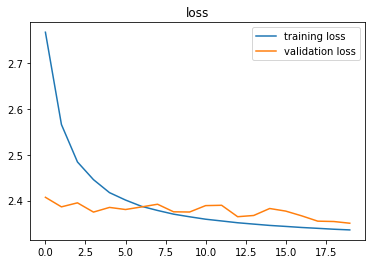

Plotting metrics...


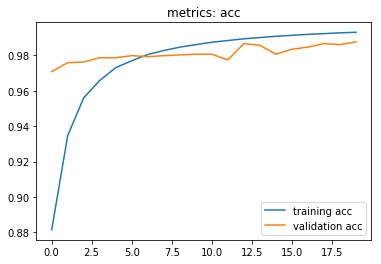

train {'acc': 1.0}
test {'acc': 0.9872}

Training student with temperature = 64 , coef = 4096 .
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12595887251129749023
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2038890496
locality {
  bus_id: 1
}
incarnation: 3600141126548078594
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]
Epoch 1 , step 0 , loss= 9435.884 , acc = 0.12 
t_cost <class 'dict'> 
get_batch : 5.000000328436727e-06
train_op : 0.06757000000015978
loss_train : 0.04893399999991743
metric batch : 0.03974599999992279
whole : 0.15659499999992477
display_whole : 0.0890070000000378
Epoch 1 , step 100 , loss= 9429.374 , acc = 0.75 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.010029000000031374
loss_train : 0.015128999999888038
metric batch : 0.00895700000000943
whole : 0.03454199999987395
display_whole : 0.024500999999872874
Epoch 1 , s

Epoch 5 , step 100 , loss= 9428.077 , acc = 0.86 
t_cost <class 'dict'> 
get_batch : 8.000000434549293e-06
train_op : 0.012447999999949388
loss_train : 0.0059569999998529966
metric batch : 0.0077379999997901905
whole : 0.026534000000083324
display_whole : 0.014068999999835796
Epoch 5 , step 200 , loss= 9428.318 , acc = 0.82 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.011793000000125176
loss_train : 0.006147999999939202
metric batch : 0.002449999999953434
whole : 0.02080599999999322
display_whole : 0.008997999999792228
Epoch 5 , step 300 , loss= 9428.569 , acc = 0.85 
t_cost <class 'dict'> 
get_batch : 6.999999641266186e-06
train_op : 0.010596000000077765
loss_train : 0.016539999999622523
metric batch : 0.005702999999812164
whole : 0.03327800000033676
display_whole : 0.022670999999718333
Epoch 5 , step 400 , loss= 9428.795 , acc = 0.87 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.005745000000388245
loss_train : 0.00737699999990582
met

Epoch 9 , step 400 , loss= 9428.506 , acc = 0.87 
t_cost <class 'dict'> 
get_batch : 7.000000096013537e-06
train_op : 0.011543999999958032
loss_train : 0.011328000000048633
metric batch : 0.0066660000002229935
whole : 0.02988599999980579
display_whole : 0.01832700000022669
Epoch 9 , step 500 , loss= 9428.639 , acc = 0.94 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.011664999999993597
loss_train : 0.008527999999841995
metric batch : 0.008127000000058615
whole : 0.028712000000268745
display_whole : 0.017034999999850697
Epoch 9 , step 549 , loss= 9428.845 val_loss= 9428.693 , acc = 0.87 val acc = 0.8498 
Epoch 9 finished, loss= 9428.802 t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.012169000000085362
loss_train : 0.014800000000377622
loss_val : 0.04503599999998187
metric_val : 0.027311000000281638
metric batch : 0.00895200000013574
whole : 0.10898700000007011
display_whole : 0.09680900000012116
Epoch 10 , step 50 , loss= 9428.731 , acc = 0

Epoch 13 , step 549 , loss= 9428.458 val_loss= 9428.672 , acc = 0.92 val acc = 0.8366 
Epoch 13 finished, loss= 9428.698 t_cost <class 'dict'> 
get_batch : 6.000000212225132e-06
train_op : 0.011162000000240369
loss_train : 0.005654999999933352
loss_val : 0.06315300000005664
metric_val : 0.02123600000004444
metric batch : 0.0029629999999087886
whole : 0.10520399999995789
display_whole : 0.09402999999974782
Epoch 14 , step 50 , loss= 9428.542 , acc = 0.89 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.009267000000363623
loss_train : 0.0030839999999443535
metric batch : 0.009550000000217551
whole : 0.022201000000222848
display_whole : 0.012921999999889522
Epoch 14 , step 150 , loss= 9428.473 , acc = 0.92 
t_cost <class 'dict'> 
get_batch : 4.999999873689376e-06
train_op : 0.011566000000129861
loss_train : 0.006414999999833526
metric batch : 0.004656000000068161
whole : 0.022906000000148197
display_whole : 0.01132999999981621
Epoch 14 , step 250 , loss= 9428.197 , a

Epoch 18 , step 150 , loss= 9428.578 , acc = 0.91 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.004778999999871303
loss_train : 0.007802000000083353
metric batch : 0.007548000000042521
whole : 0.020507000000179687
display_whole : 0.015714000000116357
Epoch 18 , step 250 , loss= 9428.362 , acc = 0.89 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.010037000000011176
loss_train : 0.015891999999894324
metric batch : 0.007689999999911379
whole : 0.034113000000161264
display_whole : 0.024068000000170287
Epoch 18 , step 350 , loss= 9428.622 , acc = 0.87 
t_cost <class 'dict'> 
get_batch : 7.999999979801942e-06
train_op : 0.012076999999862892
loss_train : 0.019592999999986205
metric batch : 0.004689000000325905
whole : 0.03679999999985739
display_whole : 0.024707999999918684
Epoch 18 , step 450 , loss= 9428.609 , acc = 0.92 
t_cost <class 'dict'> 
get_batch : 5.999999757477781e-06
train_op : 0.010051999999632244
loss_train : 0.00913700000000972


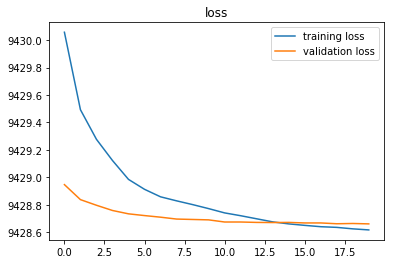

Plotting metrics...


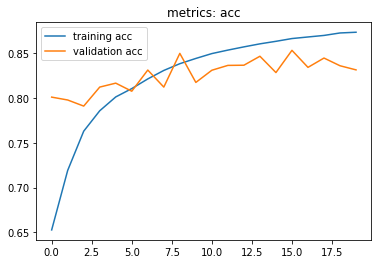

train {'acc': 0.90105456}
test {'acc': 0.8334}



In [12]:

temperatures = [2,4,8,16,32,64]
train_metrics = {}
test_metrics = {}
for temperature in temperatures:
    # initialize metrics
    train_metrics[temperature] = []
    test_metrics[temperature] = []
    # prepare softened data
    y_train_soft = teacher.predict_softened(X_train, temperature)
    y_val_soft = teacher.predict_softened(X_val, temperature)
    y_test_soft = teacher.predict_softened(X_test, temperature)
    for coef_softloss in [1/(temperature**2), 1, temperature**2]:
        print('Training student with temperature =',temperature,', coef =',coef_softloss,'.')
        # build network architecture
        student = build_small_model(input_dims, output_dims, session, is_student=True)
        # train network
        student.soft_train(
            X=X_train
            ,y=y_train
            ,y_soft=y_train_soft
            ,temperature=temperature
            ,coef_softloss= coef_softloss# * temperature**2
            ,val_set=[X_val,y_val,y_val_soft]
            ,batch_size=100
            ,n_epochs=20
            ,display_steps=100)
        # show result
        print('Student performance with temperature =',temperature,', coef =',coef_softloss,'.')
        student.plt_loss()
        student.plt_metrics()
        train_metric = student.get_metrics(X_train, y_train)
        test_metric = student.get_metrics(X_test, y_test)
        print('train',train_metric)
        print('test',test_metric)
        print()
        train_metrics[temperature].append(train_metric)
        test_metrics[temperature].append(test_metric)
        gc.collect()

In [13]:
print(test_metrics)

{2: [{'acc': 0.9801}, {'acc': 0.9662}, {'acc': 0.4499}], 4: [{'acc': 0.9801}, {'acc': 0.9806}, {'acc': 0.6753}], 8: [{'acc': 0.9856}, {'acc': 0.9842}, {'acc': 0.6307}], 16: [{'acc': 0.9794}, {'acc': 0.9859}, {'acc': 0.6928}], 32: [{'acc': 0.9807}, {'acc': 0.9848}, {'acc': 0.63}], 64: [{'acc': 0.981}, {'acc': 0.9872}, {'acc': 0.8334}]}


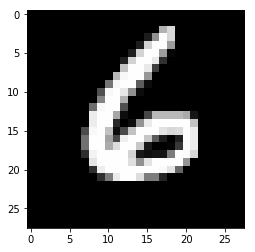

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[[1.500e-03 1.930e-02 4.100e-03 8.160e-02 1.000e-04 3.010e-02 6.050e-01
  1.220e-02 2.083e-01 3.790e-02]]
[[0.0962 0.1002 0.0978 0.1024 0.0923 0.1008 0.1057 0.0994 0.1039 0.1012]]


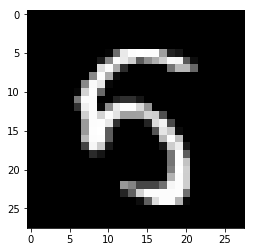

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[[0.0144 0.0058 0.0212 0.1093 0.     0.2111 0.     0.2364 0.3496 0.052 ]]
[[0.1    0.0985 0.1006 0.1032 0.0905 0.1043 0.0915 0.1044 0.1051 0.102 ]]


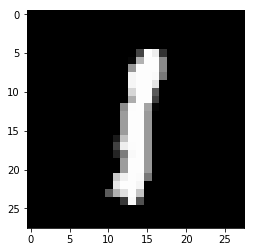

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[[3.320e-02 8.846e-01 6.100e-03 1.580e-02 7.000e-04 7.500e-03 1.800e-03
  2.410e-02 7.900e-03 1.830e-02]]
[[0.1015 0.1068 0.0989 0.1003 0.0955 0.0992 0.097  0.101  0.0992 0.1006]]


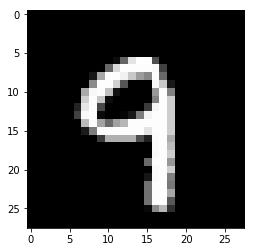

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[9.620e-02 0.000e+00 1.200e-03 4.700e-02 3.000e-04 1.100e-03 5.550e-02
  9.710e-02 1.920e-01 5.095e-01]]
[[0.1032 0.0915 0.0964 0.1021 0.0945 0.0963 0.1024 0.1033 0.1044 0.106 ]]


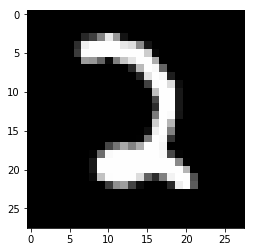

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[[0.0015 0.0286 0.8568 0.0364 0.0108 0.017  0.0034 0.0245 0.0201 0.0009]]
[[0.0965 0.101  0.1066 0.1014 0.0995 0.1002 0.0977 0.1008 0.1005 0.0957]]


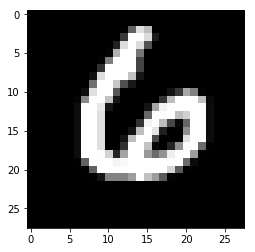

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[[2.000e-03 2.450e-02 1.000e-04 2.400e-03 9.000e-04 3.600e-03 8.436e-01
  3.000e-02 4.750e-02 4.540e-02]]
[[0.0977 0.1016 0.0933 0.098  0.0965 0.0986 0.1074 0.1019 0.1026 0.1026]]


In [14]:
# plot and show sample # deprecated
if try_cls2 and True:
    n_samples = 6
    round_show = 4
    n_data = X_test.shape[0]
    indices = np.random.choice(n_data,n_samples)
    for i in range(n_samples):
        sample = X_test[[indices[i]]]
        label = y_test[indices[i]]
        plt.imshow(sample.reshape((28,28)), cmap='gray')
        plt.show()
        pred = student.predict(sample)
        pred_t = student.predict_softened(sample, temperature=temperature)
        print(label)
        print(np.round(pred,round_show))
        print(np.round(pred_t,round_show))
#         print(np.round(pred_t2,round_show))
        #     student.predict()

In [15]:
# close_session(session)